In [28]:
# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json


from utils.save import *



In [29]:
# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'mean_last_100_loss' # ou 'mean_last_100_loss'

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

In [30]:
# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

all_dfs = []

try:
    df_classic = pd.read_csv(SUMMARY_CLASSIC_PATH)
    all_dfs.append(df_classic)
    print(f"Carregado {len(df_classic)} runs de '{SUMMARY_CLASSIC_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CLASSIC_PATH}' não encontrado. Pulando.")

try:
    df_hybrid = pd.read_csv(SUMMARY_HYBRID_PATH)
    all_dfs.append(df_hybrid)
    print(f"Carregado {len(df_hybrid)} runs de '{SUMMARY_HYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_HYBRID_PATH}' não encontrado. Pulando.")

try:
    df_quantum = pd.read_csv(SUMMARY_QUANTUM_PATH)
    all_dfs.append(df_quantum)
    print(f"Carregado {len(df_quantum)} runs de '{SUMMARY_QUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_QUANTUM_PATH}' não encontrado. Pulando.")

try:
    df_quantum = pd.read_csv(SUMMARY_CQUANTUM_PATH)
    all_dfs.append(df_quantum)
    print(f"Carregado {len(df_quantum)} runs de '{SUMMARY_CQUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CQUANTUM_PATH}' não encontrado. Pulando.")
try:
    df_chybrid = pd.read_csv(SUMMARY_CHYBRID_PATH)
    all_dfs.append(df_chybrid)
    print(f"Carregado {len(df_chybrid)} runs de '{SUMMARY_CHYBRID_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CHYBRID_PATH}' não encontrado. Pulando.")



if not all_dfs:
    print("ERRO: Nenhum arquivo de sumário encontrado. Rode 'run_experiments.py' primeiro.")
    exit()

# Concatena todos os dataframes para análise comparativa
df_all = pd.concat(all_dfs, ignore_index=True)

Carregado 210 runs de 'experimentos_pinn/sumario_classico.csv'
Carregado 192 runs de 'experimentos_pinn/sumario_hibrido.csv'
Carregado 189 runs de 'experimentos_pinn/sumario_quantico.csv'
Carregado 282 runs de 'experimentos_pinn/sumario_cquantico.csv'
Carregado 359 runs de 'experimentos_pinn/sumario_chibrido.csv'


In [31]:
#df_all[df_all["model_type"] == "CQNN"]
#df_cqnn

# 1) CQNN effect

## 1.1) Same #'s output - Strong

In [55]:
# ==========================================
# 1. Filtragem dos dados
# ==========================================
entangler = 'strong'
df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_qubits"] == 7)
]

df_cqnn = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_vertex"] == 7)
]

/tmp/ipykernel_3365/3312424821.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_qnn = ax.boxplot(data_qnn, labels=labels_qnn)
/tmp/ipykernel_3365/3312424821.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_k2 = ax.boxplot(data_k2, labels=labels_k2)
/tmp/ipykernel_3365/3312424821.py:142: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_k3 = ax.boxplot(data_k3, labels=labels_k3)


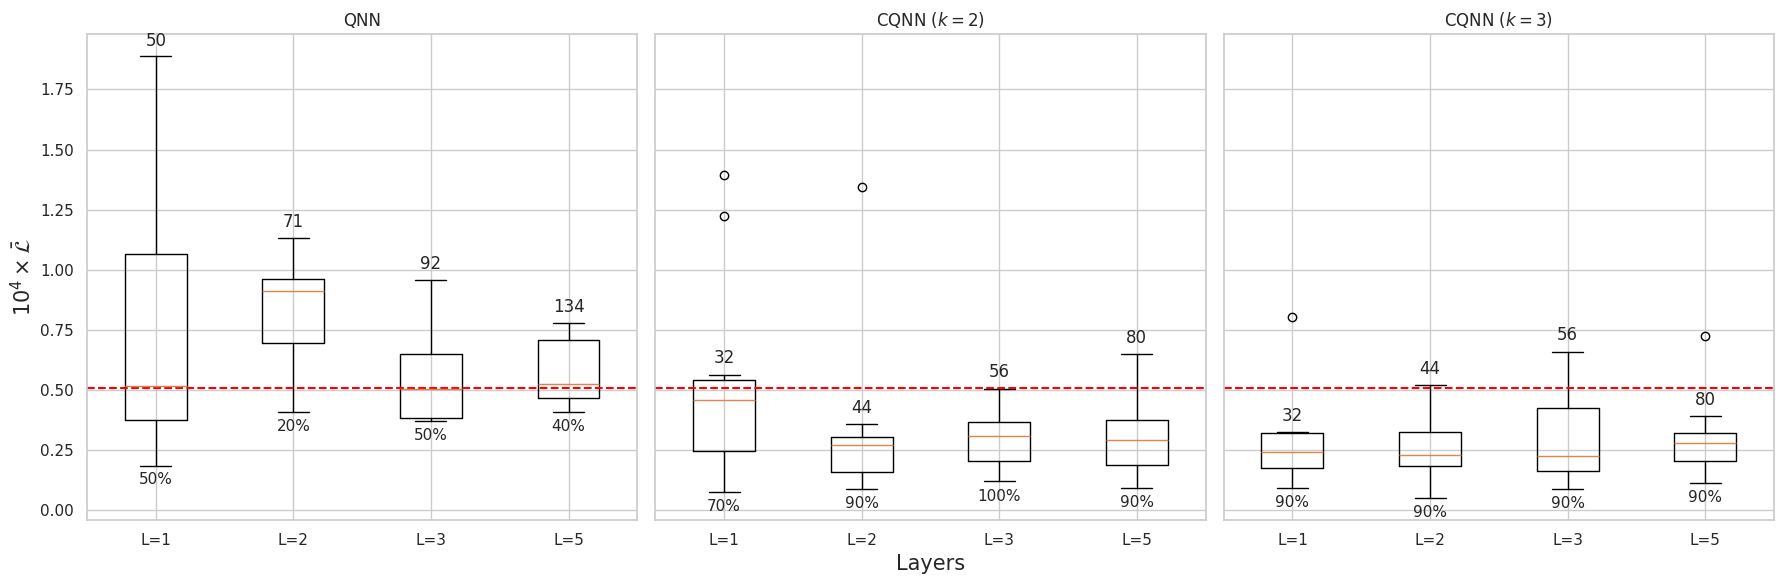

QNN: {1: 10, 2: 10, 3: 10, 5: 10}
CQNN k=2: {1: 10, 2: 10, 3: 10, 5: 10}
CQNN k=3: {1: 10, 2: 10, 3: 10, 5: 10}


In [56]:
# ==========================================
# 2. Fator de escala
# ==========================================
factor = 10**4

# ==========================================
# 3. Agrupamento — QNN
# ==========================================
groups_qnn = df_qnn.groupby("n_layers")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_qnn = groups_qnn.tolist()
labels_qnn = [f"L={nl}" for nl in groups_qnn.index]

# num_params agrupado por L
params_qnn = df_qnn.groupby("n_layers")["num_params"].first().to_dict()

# ==========================================
# 4. Agrupamento — CQNN por K=2 e K=3
# ==========================================
groups_cqnn_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
groups_cqnn_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)

data_k2 = groups_cqnn_k2.tolist()
data_k3 = groups_cqnn_k3.tolist()

labels_k2 = [f"L={nl}" for nl in groups_cqnn_k2.index]
labels_k3 = [f"L={nl}" for nl in groups_cqnn_k3.index]

params_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")["num_params"].first().to_dict()
params_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")["num_params"].first().to_dict()

# ==========================================
# Taxa de convergência
# ==========================================
def compute_conv(groups, thr):
    conv = {}
    for L, vals in groups.items():
        arr = np.asarray(vals)
        conv[L] = 100 * np.mean(arr < thr)
    return conv

threshold = (1 / 140**2) * factor
conv_qnn = compute_conv(groups_qnn, threshold)
conv_k2  = compute_conv(groups_cqnn_k2, threshold)
conv_k3  = compute_conv(groups_cqnn_k3, threshold)

# ==========================================
# 5. Plotagem lado a lado (3 colunas)
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# ---- QNN ----
ax = axes[0]
bp_qnn = ax.boxplot(data_qnn, labels=labels_qnn)
ax.set_title("QNN")
ax.set_ylabel("$10^{4} \\times \\bar{\\mathcal{L}}$", fontsize=15)
ax.grid(True)

# linha do threshold
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

# margem vertical para os textos (3% da altura do eixo)
ymin, ymax = ax.get_ylim()
delta_qnn = (ymax - ymin) * 0.015

for i, L in enumerate(groups_qnn.index):
    x_pos = i + 1

    # whiskers: 2*i (inferior), 2*i+1 (superior)
    w_low  = bp_qnn["whiskers"][2*i]
    w_high = bp_qnn["whiskers"][2*i + 1]

    # extremos dos whiskers (sem outliers)
    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    # num_params acima do whisker superior
    ax.text(
        x_pos,
        y_high + delta_qnn,
        f"{params_qnn[L]}",
        ha="center",
        va="bottom",
        fontsize=12
    )

    # taxa de convergência abaixo do whisker inferior
    ax.text(
        x_pos,
        y_low - delta_qnn,
        f"{conv_qnn[L]:.0f}%",
        ha="center",
        va="top",
        fontsize=11
    )

# ---- CQNN K=2 ----
ax = axes[1]
bp_k2 = ax.boxplot(data_k2, labels=labels_k2)
ax.set_title("CQNN ($k = 2$)")
ax.set_xlabel("Layers", fontsize=15)
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ymin, ymax = ax.get_ylim()
delta_k2 = (ymax - ymin) * 0.015

for i, L in enumerate(groups_cqnn_k2.index):
    x_pos = i + 1

    w_low  = bp_k2["whiskers"][2*i]
    w_high = bp_k2["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(
        x_pos,
        y_high + delta_k2,
        f"{params_k2[L]}",
        ha="center",
        va="bottom",
        fontsize=12
    )
    ax.text(
        x_pos,
        y_low - delta_k2,
        f"{conv_k2[L]:.0f}%",
        ha="center",
        va="top",
        fontsize=11
    )

# ---- CQNN K=3 ----
ax = axes[2]
bp_k3 = ax.boxplot(data_k3, labels=labels_k3)
ax.set_title("CQNN ($k = 3$)")
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ymin, ymax = ax.get_ylim()
delta_k3 = (ymax - ymin) * 0.015

for i, L in enumerate(groups_cqnn_k3.index):
    x_pos = i + 1

    w_low  = bp_k3["whiskers"][2*i]
    w_high = bp_k3["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(
        x_pos,
        y_high + delta_k3,
        f"{params_k3[L]}",
        ha="center",
        va="bottom",
        fontsize=12
    )
    ax.text(
        x_pos,
        y_low - delta_k3,
        f"{conv_k3[L]:.0f}%",
        ha="center",
        va="top",
        fontsize=11
    )

plt.tight_layout()
plt.show()

# Contagens por L
counts_qnn = {L: len(vals) for L, vals in groups_qnn.items()}
counts_k2  = {L: len(vals) for L, vals in groups_cqnn_k2.items()}
counts_k3  = {L: len(vals) for L, vals in groups_cqnn_k3.items()}

print("QNN:", counts_qnn)
print("CQNN k=2:", counts_k2)
print("CQNN k=3:", counts_k3)


/tmp/ipykernel_3365/2611442570.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_qnn = ax.boxplot(data_qnn, labels=labels_qnn)
/tmp/ipykernel_3365/2611442570.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_k2 = ax.boxplot(data_k2, labels=labels_k2)
/tmp/ipykernel_3365/2611442570.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp_k3 = ax.boxplot(data_k3, labels=labels_k3)


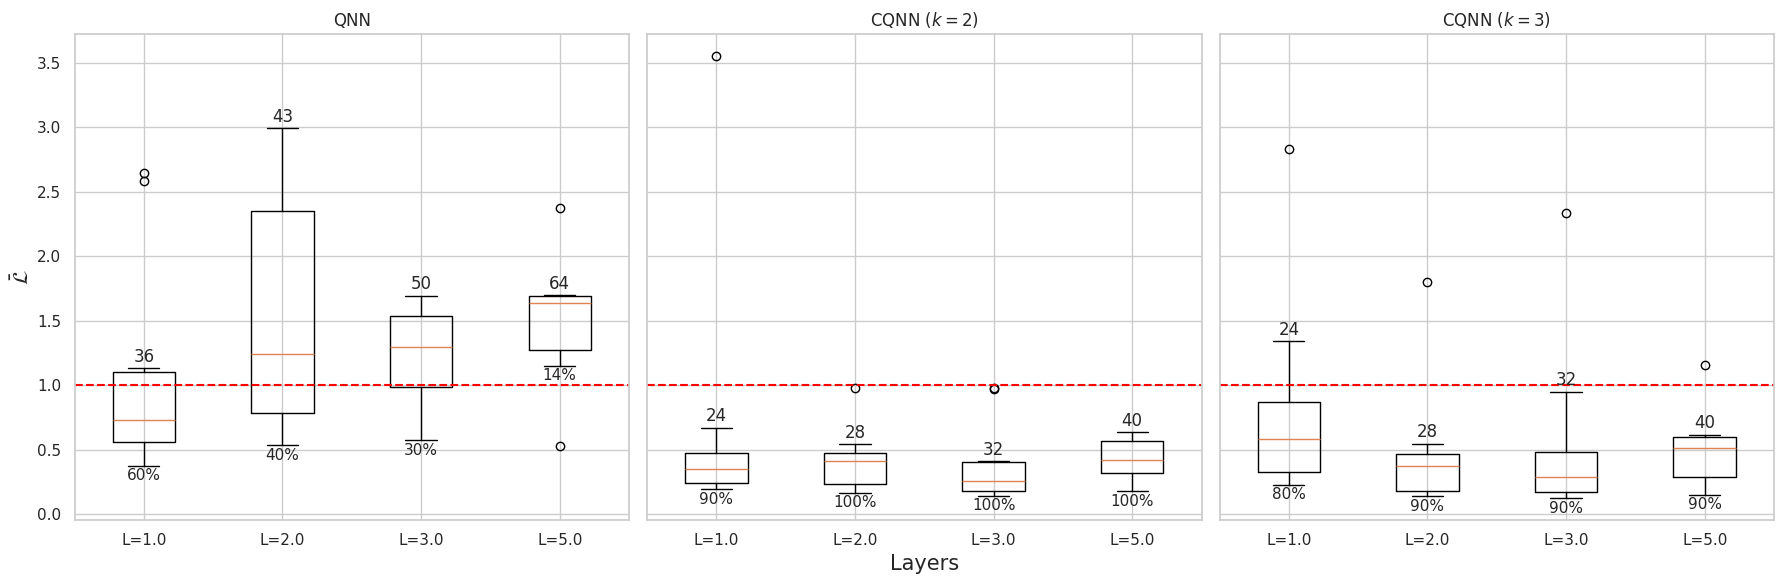

In [34]:
# ==========================================
# 2. Métrica a ser usada
# ==========================================
test = "mse_teste_desnormalizado"

# ==========================================
# 3. Agrupamento — QNN
# ==========================================
groups_qnn = df_qnn.groupby("n_layers")[test].apply(lambda x: x.tolist())
data_qnn = groups_qnn.tolist()
labels_qnn = [f"L={nl}" for nl in groups_qnn.index]
params_qnn = df_qnn.groupby("n_layers")["num_params"].first().to_dict()

# ==========================================
# 4. Agrupamento — CQNN por K=2 e K=3
# ==========================================
groups_cqnn_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")[test].apply(lambda x: x.tolist())
groups_cqnn_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")[test].apply(lambda x: x.tolist())

data_k2 = groups_cqnn_k2.tolist()
data_k3 = groups_cqnn_k3.tolist()

labels_k2 = [f"L={nl}" for nl in groups_cqnn_k2.index]
labels_k3 = [f"L={nl}" for nl in groups_cqnn_k3.index]

params_k2 = df_cqnn[df_cqnn["k"] == 2].groupby("n_layers")["num_params"].first().to_dict()
params_k3 = df_cqnn[df_cqnn["k"] == 3].groupby("n_layers")["num_params"].first().to_dict()

# --------- Taxa de convergência ----------
import numpy as np

def compute_conv(groups, thr):
    conv = {}
    for L, vals in groups.items():
        arr = np.asarray(vals)
        conv[L] = 100 * np.mean(arr < thr)
    return conv

threshold = 1
conv_qnn = compute_conv(groups_qnn, threshold)
conv_k2  = compute_conv(groups_cqnn_k2, threshold)
conv_k3  = compute_conv(groups_cqnn_k3, threshold)

# ==========================================
# 5. Plotagem lado a lado (3 colunas)
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# ---- CONFIGURAÇÃO ----
delta = 0.02   # <<< espaçamento pedido

# ==========================================
#  QNN
# ==========================================
ax = axes[0]
bp_qnn = ax.boxplot(data_qnn, labels=labels_qnn)
ax.set_title("QNN")
ax.set_ylabel(r"$\bar{\mathcal{L}}$", fontsize=15)
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

for i, L in enumerate(groups_qnn.index):
    x_pos = i + 1

    # whiskers
    w_low  = bp_qnn["whiskers"][2*i]
    w_high = bp_qnn["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(x_pos, y_high + delta, f"{params_qnn[L]}",
            ha="center", va="bottom", fontsize=12)

    ax.text(x_pos, y_low - delta, f"{conv_qnn[L]:.0f}%",
            ha="center", va="top", fontsize=11)

# ==========================================
#  CQNN k = 2
# ==========================================
ax = axes[1]
bp_k2 = ax.boxplot(data_k2, labels=labels_k2)
ax.set_title("CQNN ($k = 2$)")
ax.set_xlabel("Layers", fontsize=15)
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

for i, L in enumerate(groups_cqnn_k2.index):
    x_pos = i + 1

    w_low  = bp_k2["whiskers"][2*i]
    w_high = bp_k2["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(x_pos, y_high + delta, f"{params_k2[L]}",
            ha="center", va="bottom", fontsize=12)

    ax.text(x_pos, y_low - delta, f"{conv_k2[L]:.0f}%",
            ha="center", va="top", fontsize=11)

# ==========================================
#  CQNN k = 3
# ==========================================
ax = axes[2]
bp_k3 = ax.boxplot(data_k3, labels=labels_k3)
ax.set_title("CQNN ($k = 3$)")
ax.grid(True)

ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

for i, L in enumerate(groups_cqnn_k3.index):
    x_pos = i + 1

    w_low  = bp_k3["whiskers"][2*i]
    w_high = bp_k3["whiskers"][2*i + 1]

    y_low  = min(w_low.get_ydata())
    y_high = max(w_high.get_ydata())

    ax.text(x_pos, y_high + delta, f"{params_k3[L]}",
            ha="center", va="bottom", fontsize=12)

    ax.text(x_pos, y_low - delta, f"{conv_k3[L]:.0f}%",
            ha="center", va="top", fontsize=11)

plt.tight_layout()
plt.show()


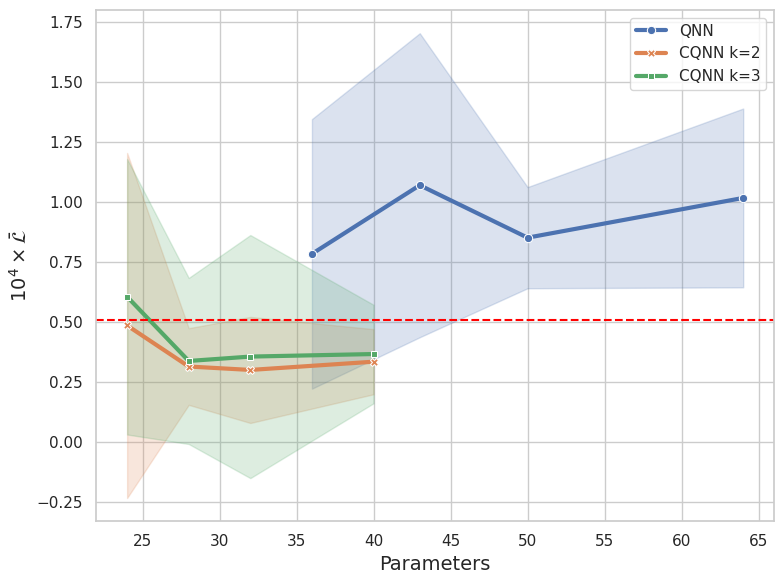

In [35]:
import seaborn as sns

factor = 10**4

# ----- preparar dataframes com coluna de modelo -----
df_qnn_plot = df_qnn.copy()
df_qnn_plot["model"] = "QNN"

df_k2_plot = df_cqnn[df_cqnn["k"] == 2].copy()
df_k2_plot["model"] = "CQNN k=2"

df_k3_plot = df_cqnn[df_cqnn["k"] == 3].copy()
df_k3_plot["model"] = "CQNN k=3"

# coluna com loss escalada
for df_ in (df_qnn_plot, df_k2_plot, df_k3_plot):
    df_["loss_scaled"] = df_["mean_last_100_loss"] * factor

# junta tudo num único DF
df_lines = pd.concat([df_qnn_plot, df_k2_plot, df_k3_plot], ignore_index=True)

# ----- plot com seaborn: linha + incerteza -----
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=df_lines,
    x="num_params",
    y="loss_scaled",
    hue="model",
    style="model",
    lw=3,
    markers=True,
    dashes=False,
    errorbar="sd",    # média ± desvio padrão
    ax=ax
)

threshold = (1 / 140**2) * factor
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ax.set_xlabel("Parameters", fontsize=14)
ax.set_ylabel(r"$10^{4} \times \bar{\mathcal{L}}$", fontsize=14)
ax.legend(title=None)
plt.tight_layout()
plt.show()

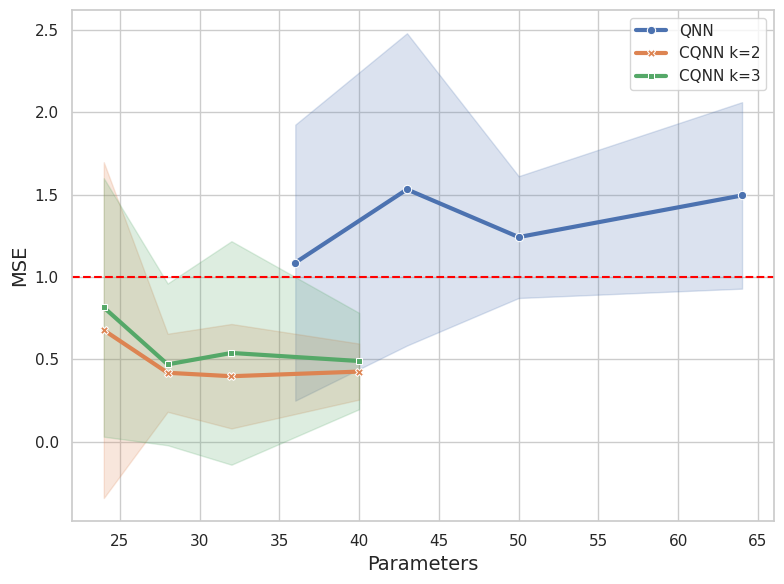

In [36]:
# ----- preparar dataframes com coluna de modelo -----
df_qnn_plot = df_qnn.copy()
df_qnn_plot["model"] = "QNN"

df_k2_plot = df_cqnn[df_cqnn["k"] == 2].copy()
df_k2_plot["model"] = "CQNN k=2"

df_k3_plot = df_cqnn[df_cqnn["k"] == 3].copy()
df_k3_plot["model"] = "CQNN k=3"

# coluna com loss escalada
for df_ in (df_qnn_plot, df_k2_plot, df_k3_plot):
    df_["loss_scaled"] = df_[test]

# junta tudo num único DF
df_lines = pd.concat([df_qnn_plot, df_k2_plot, df_k3_plot], ignore_index=True)

# ----- plot com seaborn: linha + incerteza -----
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=df_lines,
    x="num_params",
    y="loss_scaled",
    hue="model",
    style="model",
    lw=3,
    markers=True,
    dashes=False,
    errorbar="sd",    # média ± desvio padrão
    ax=ax
)

threshold = 1
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ax.set_xlabel("Parameters", fontsize=14)
ax.set_ylabel("MSE", fontsize=14)
ax.legend(title=None)
plt.tight_layout()
plt.show()

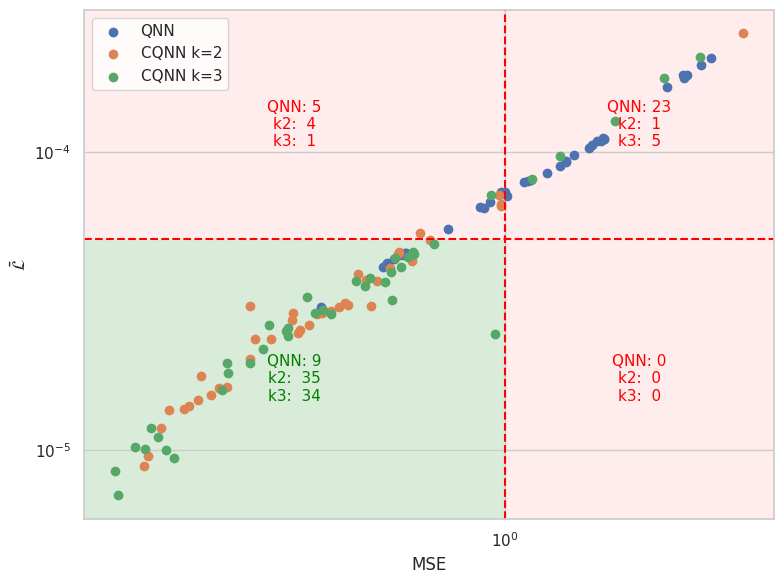

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# -----------------------------
# suas variáveis e dados
# -----------------------------
x_qnn = df_qnn_plot['mse_teste_desnormalizado'].values
y_qnn = df_qnn_plot['mean_last_100_loss'].values

x_k2  = df_k2_plot['mse_teste_desnormalizado'].values
y_k2  = df_k2_plot['mean_last_100_loss'].values

x_k3  = df_k3_plot['mse_teste_desnormalizado'].values
y_k3  = df_k3_plot['mean_last_100_loss'].values

tx = 1        # threshold em x (MSE normalizado)
ty = 1 / 140**2             # threshold em y (loss)

# -----------------------------
# função p/ contagem de quadrantes
# -----------------------------
def quadrant_counts(x, y, tx, ty):
    x = np.asarray(x); y = np.asarray(y)
    return {
        "Q1": np.sum((x >= tx) & (y >= ty)),  # cima-direita
        "Q2": np.sum((x <  tx) & (y >= ty)),  # cima-esquerda
        "Q3": np.sum((x <  tx) & (y <  ty)),  # baixo-esquerda
        "Q4": np.sum((x >= tx) & (y <  ty)),  # baixo-direita
    }

cnt_qnn = quadrant_counts(x_qnn, y_qnn, tx, ty)
cnt_k2  = quadrant_counts(x_k2,  y_k2,  tx, ty)
cnt_k3  = quadrant_counts(x_k3,  y_k3,  tx, ty)

# -----------------------------
# plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(x_qnn, y_qnn, label="QNN")
ax.scatter(x_k2,  y_k2,  label="CQNN k=2")
ax.scatter(x_k3,  y_k3,  label="CQNN k=3")

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE")
ax.set_ylabel("$\\bar{\\mathcal{L}}$")

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=1.5)
ax.axvline(tx, color='red', linestyle='--', linewidth=1.5)

# limites (depois de plottar e setar log!)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# -----------------------------
# quadrantes com Rectangle
# -----------------------------
# quadrante bom (baixo-esquerda) – verde
ax.add_patch(Rectangle(
    (x_min, y_min),           # canto inferior esquerdo
    tx - x_min,               # largura
    ty - y_min,               # altura
    facecolor='green', alpha=0.15, zorder=0
))

# cima-esquerda – vermelho claro
ax.add_patch(Rectangle(
    (x_min, ty),
    tx - x_min,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# baixo-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, y_min),
    x_max - tx,
    ty - y_min,
    facecolor='red', alpha=0.07, zorder=0
))

# cima-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, ty),
    x_max - tx,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# garantir que limites não mudem
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# -----------------------------
# posições dos textos (meio geométrico em log)
# -----------------------------
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

# baixo-esquerda (Q3) – verde
ax.text(
    xL, yB,
    f"QNN: {cnt_qnn['Q3']}\n"
    f"k2:  {cnt_k2['Q3']}\n"
    f"k3:  {cnt_k3['Q3']}",
    color='green', fontsize=11, ha='center', va='center'
)

# cima-esquerda (Q2) – vermelho
ax.text(
    xL, yT,
    f"QNN: {cnt_qnn['Q2']}\n"
    f"k2:  {cnt_k2['Q2']}\n"
    f"k3:  {cnt_k3['Q2']}",
    color='red', fontsize=11, ha='center', va='center'
)

# baixo-direita (Q4) – vermelho
ax.text(
    xR, yB,
    f"QNN: {cnt_qnn['Q4']}\n"
    f"k2:  {cnt_k2['Q4']}\n"
    f"k3:  {cnt_k3['Q4']}",
    color='red', fontsize=11, ha='center', va='center'
)

# cima-direita (Q1) – vermelho
ax.text(
    xR, yT,
    f"QNN: {cnt_qnn['Q1']}\n"
    f"k2:  {cnt_k2['Q1']}\n"
    f"k3:  {cnt_k3['Q1']}",
    color='red', fontsize=11, ha='center', va='center'
)

ax.legend()
plt.tight_layout()
plt.show()



## 1.2) Same #'s qubits - Strong

In [57]:
# =========================================================
# 0. Configuração
# =========================================================
n_layers_fixed = 3        # <-- escolha aqui o número de layers fixo
entangler = "strong"      # ou "basic"
factor = 10**4
threshold = (1 / 140**2) * factor

n_qubits_cqnn_fixed = 4  # <-- ajuste aqui

/tmp/ipykernel_3365/810016178.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_qnn, labels=labels_qnn)
/tmp/ipykernel_3365/810016178.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_k2, labels=labels_k2)
/tmp/ipykernel_3365/810016178.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_k3, labels=labels_k3)


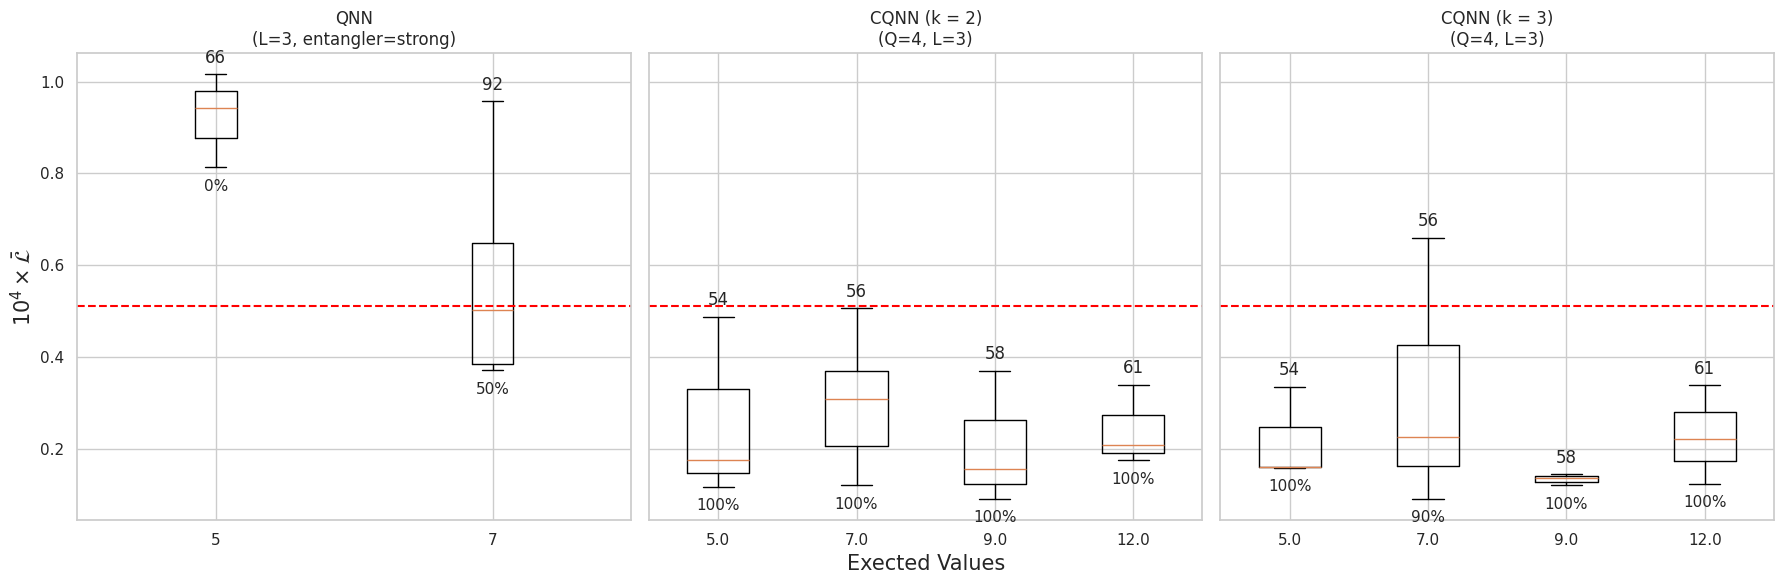

QNN: {5: 3, 7: 10}
CQNN k=2: {5.0: 3, 7.0: 10, 9.0: 3, 12.0: 3}
CQNN k=3: {5.0: 3, 7.0: 10, 9.0: 3, 12.0: 3}


In [58]:

# =========================================================
# 1. Filtragem dos dados
#    - fixa n_layers e entangler
#    - QNN: deixa n_qubits variar
#    - CQNN: fixa n_qubits (pra comparar) e deixa n_vertex variar
# =========================================================

# QNN: varia n_qubits, fixa layers
df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_layers"] == n_layers_fixed)
]


df_cqnn = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_layers"] == n_layers_fixed) &
    (df_all["n_qubits"] == n_qubits_cqnn_fixed)
]

# =========================================================
# 2. Função para taxa de convergência
# =========================================================
def compute_conv(groups, thr):
    conv = {}
    for key, vals in groups.items():
        arr = np.asarray(vals)
        conv[key] = 100 * np.mean(arr < thr)
    return conv

# =========================================================
# 3. Agrupamento — QNN (x = n_qubits)
# =========================================================
groups_qnn = df_qnn.groupby("n_qubits")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_qnn = groups_qnn.tolist()
labels_qnn = [f"{q}" for q in groups_qnn.index]  # só o número

params_qnn = df_qnn.groupby("n_qubits")["num_params"].first().to_dict()
conv_qnn = compute_conv(groups_qnn, threshold)

# =========================================================
# 4. Agrupamento — CQNN por k e n_vertex (x = n_vertex)
# =========================================================

# k = 2
df_k2 = df_cqnn[df_cqnn["k"] == 2]
groups_k2 = df_k2.groupby("n_vertex")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_k2 = groups_k2.tolist()
labels_k2 = [f"{v}" for v in groups_k2.index]
params_k2 = df_k2.groupby("n_vertex")["num_params"].first().to_dict()
conv_k2 = compute_conv(groups_k2, threshold)

# k = 3
df_k3 = df_cqnn[df_cqnn["k"] == 3]
groups_k3 = df_k3.groupby("n_vertex")["mean_last_100_loss"].apply(
    lambda x: (x * factor).tolist()
)
data_k3 = groups_k3.tolist()
labels_k3 = [f"{v}" for v in groups_k3.index]
params_k3 = df_k3.groupby("n_vertex")["num_params"].first().to_dict()
conv_k3 = compute_conv(groups_k3, threshold)

# =========================================================
# 5. Plotagem lado a lado (3 colunas)
# =========================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
offset = 0.025  # deslocamento vertical pros textos

# ---- Painel 1: QNN (x = n_qubits) ----
ax = axes[0]
if len(data_qnn) > 0:
    ax.boxplot(data_qnn, labels=labels_qnn)
ax.set_title(f"QNN\n(L={n_layers_fixed}, entangler={entangler})")
ax.set_ylabel(r"$10^{4} \times \bar{\mathcal{L}}$", fontsize=15)
#ax.set_xlabel("n_qubits", fontsize=12)
ax.grid(True)

for i, q in enumerate(groups_qnn.index):
    x_pos = i + 1
    vals = data_qnn[i]
    y_top = np.nanmax(vals)
    y_bot = np.nanmin(vals)

    # num_params em cima
    ax.text(x_pos, y_top + offset, f"{params_qnn[q]}", ha="center", fontsize=12)
    # taxa de convergência embaixo
    ax.text(
        x_pos,
        y_bot - offset,
        f"{conv_qnn[q]:.0f}%",
        ha="center",
        va="top",
        fontsize=11,
    )

# ---- Painel 2: CQNN k = 2 (x = n_vertex) ----
ax = axes[1]
if len(data_k2) > 0:
    ax.boxplot(data_k2, labels=labels_k2)
ax.set_title(f"CQNN (k = 2)\n(Q={n_qubits_cqnn_fixed}, L={n_layers_fixed})")
ax.set_xlabel("Exected Values", fontsize=15)
ax.grid(True)

for i, v in enumerate(groups_k2.index):
    x_pos = i + 1
    vals = data_k2[i]
    y_top = np.nanmax(vals)
    y_bot = np.nanmin(vals)

    ax.text(x_pos, y_top + offset, f"{params_k2[v]}", ha="center", fontsize=12)
    ax.text(
        x_pos,
        y_bot - offset,
        f"{conv_k2[v]:.0f}%",
        ha="center",
        va="top",
        fontsize=11,
    )

# ---- Painel 3: CQNN k = 3 (x = n_vertex) ----
ax = axes[2]
if len(data_k3) > 0:
    ax.boxplot(data_k3, labels=labels_k3)
ax.set_title(f"CQNN (k = 3)\n(Q={n_qubits_cqnn_fixed}, L={n_layers_fixed})")
#ax.set_xlabel("n_vertex", fontsize=12)
ax.grid(True)

for i, v in enumerate(groups_k3.index):
    x_pos = i + 1
    vals = data_k3[i]
    y_top = np.nanmax(vals)
    y_bot = np.nanmin(vals)

    ax.text(x_pos, y_top + offset, f"{params_k3[v]}", ha="center", fontsize=12)
    ax.text(
        x_pos,
        y_bot - offset,
        f"{conv_k3[v]:.0f}%",
        ha="center",
        va="top",
        fontsize=11,
    )

# ---- Linha do threshold ----
for ax in axes:
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.show()

counts_qnn = {q: len(vals) for q, vals in groups_qnn.items()}
counts_k2  = {v: len(vals) for v, vals in groups_k2.items()}
counts_k3  = {v: len(vals) for v, vals in groups_k3.items()}

print("QNN:", counts_qnn)        # q -> número de runs pra aquele n_qubits
print("CQNN k=2:", counts_k2)    # v -> número de runs pra aquele n_vertex
print("CQNN k=3:", counts_k3)



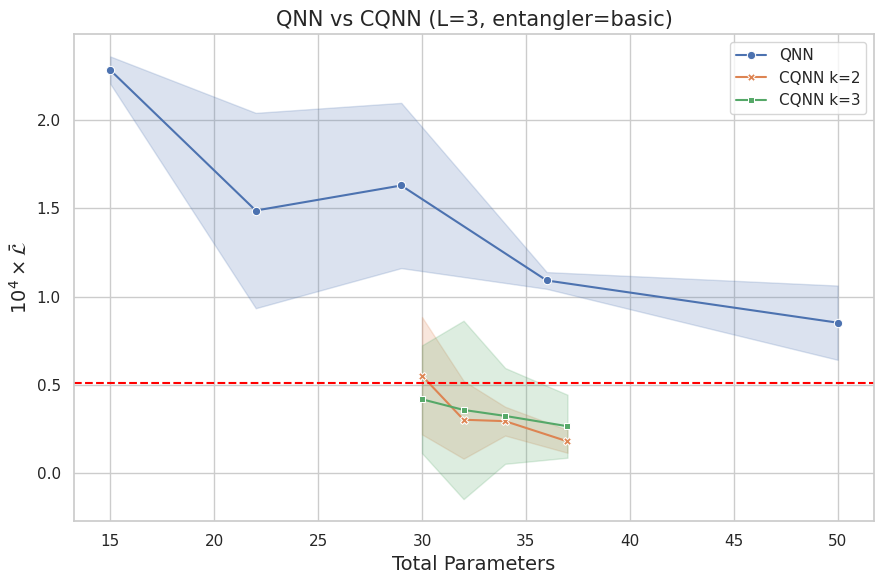

In [40]:
# =========================================================
# 1. Preparar dataframes para plot
# =========================================================

# QNN → variando n_qubits
df_qnn_plot = df_qnn.copy()
df_qnn_plot["model"] = "QNN"

# CQNN k=2 → variando n_vertex
df_k2_plot = df_cqnn[df_cqnn["k"] == 2].copy()
df_k2_plot["model"] = "CQNN k=2"

# CQNN k=3 → variando n_vertex
df_k3_plot = df_cqnn[df_cqnn["k"] == 3].copy()
df_k3_plot["model"] = "CQNN k=3"

# coluna com loss escalada
for df_ in (df_qnn_plot, df_k2_plot, df_k3_plot):
    df_["loss_scaled"] = df_["mean_last_100_loss"] * factor

# dataframe unificado
df_lines = pd.concat([df_qnn_plot, df_k2_plot, df_k3_plot], ignore_index=True)

# =========================================================
# 2. Lineplot
# =========================================================
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(
    data=df_lines,
    x="num_params",         # <--- AGORA O EIXO X É NÚMERO DE PARÂMETROS
    y="loss_scaled",
    hue="model",
    style="model",
    markers=True,
    dashes=False,
    errorbar="sd",          # média ± desvio padrão
    ax=ax
)

threshold = (1 / 140**2) * factor
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ax.set_xlabel("Total Parameters", fontsize=14)
ax.set_ylabel(r"$10^{4} \times \bar{\mathcal{L}}$", fontsize=14)
ax.set_title(f"QNN vs CQNN (L={n_layers_fixed}, entangler={entangler})", fontsize=15)

ax.legend(title=None)
plt.tight_layout()
plt.show()


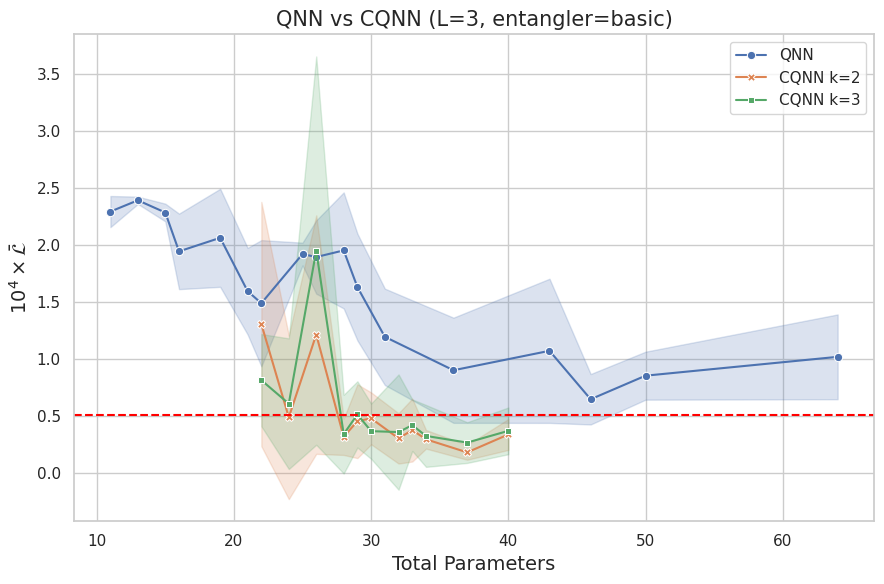

In [41]:
df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == entangler)
]


df_cqnn = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == entangler) &
    (df_all["n_qubits"] == n_qubits_cqnn_fixed)
]


# =========================================================
# 1. Preparar dataframes para plot
# =========================================================

# QNN → variando n_qubits
df_qnn_plot = df_qnn.copy()
df_qnn_plot["model"] = "QNN"

# CQNN k=2 → variando n_vertex
df_k2_plot = df_cqnn[df_cqnn["k"] == 2].copy()
df_k2_plot["model"] = "CQNN k=2"

# CQNN k=3 → variando n_vertex
df_k3_plot = df_cqnn[df_cqnn["k"] == 3].copy()
df_k3_plot["model"] = "CQNN k=3"

# coluna com loss escalada
for df_ in (df_qnn_plot, df_k2_plot, df_k3_plot):
    df_["loss_scaled"] = df_["mean_last_100_loss"] * factor

# dataframe unificado
df_lines = pd.concat([df_qnn_plot, df_k2_plot, df_k3_plot], ignore_index=True)

# =========================================================
# 2. Lineplot
# =========================================================
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(
    data=df_lines,
    x="num_params",         # <--- AGORA O EIXO X É NÚMERO DE PARÂMETROS
    y="loss_scaled",
    hue="model",
    style="model",
    markers=True,
    dashes=False,
    errorbar="sd",          # média ± desvio padrão
    ax=ax
)

threshold = (1 / 140**2) * factor
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5)

ax.set_xlabel("Total Parameters", fontsize=14)
ax.set_ylabel(r"$10^{4} \times \bar{\mathcal{L}}$", fontsize=14)
ax.set_title(f"QNN vs CQNN (L={n_layers_fixed}, entangler={entangler})", fontsize=15)

ax.legend(title=None)
plt.tight_layout()
plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # importa o 3D
from matplotlib import cm

# ===============================
# 1) Filtra os três modelos
# ===============================

df_qnn = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["entangler"] == "strong")
]

df_cqnn_k1 = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == "strong") &
    (df_all["k"] == 1)
]

df_cqnn_k2 = df_all[
    (df_all["model_type"] == "CQNN") &
    (df_all["entangler"] == "strong") &
    (df_all["k"] == 2)
]

# ===============================
# 2) Função auxiliar:
#    monta uma matriz [layers x qubits]
#    com a *melhor* (mínima) loss
# ===============================

def best_loss_matrix(df, qubit_col="n_qubits", layer_col="n_layers",
                     loss_col="mean_last_100_loss"):
    qubits = sorted(df[qubit_col].unique())
    layers = sorted(df[layer_col].unique())

    M = np.full((len(layers), len(qubits)), np.nan)

    for i, L in enumerate(layers):
        for j, Q in enumerate(qubits):
            sub = df[(df[layer_col] == L) & (df[qubit_col] == Q)]
            if len(sub) > 0:
                M[i, j] = sub[loss_col].min()   # melhor loss (mínima)

    return M, qubits, layers

M_qnn, qubits_qnn, layers_qnn = best_loss_matrix(df_qnn)
M_k1,  qubits_k1,  layers_k1  = best_loss_matrix(df_cqnn_k1, qubit_col="n_vertex")
M_k2,  qubits_k2,  layers_k2  = best_loss_matrix(df_cqnn_k2, qubit_col="n_vertex")


Carregando sumários de resultados...
Carregado 189 runs de 'experimentos_pinn/sumario_quantico.csv'
Carregado 282 runs de 'experimentos_pinn/sumario_cquantico.csv'

--- Sumário dos Experimentos (Amostra) ---
  model_type run_id_prefix     lr  epochs  activation entangler  n_qubits  \
0        QNN     qnn_basic  0.002   15000         NaN     basic         2   
1        QNN     qnn_basic  0.002   15000         NaN     basic         2   
2        QNN     qnn_basic  0.002   15000         NaN     basic         2   
3        QNN     qnn_basic  0.002   15000         NaN     basic         2   
4        QNN     qnn_basic  0.002   15000         NaN     basic         2   

   n_layers  seed                                run_id  ...  \
0         1  1924  qnn_basic_n_qubits_2_n_l_1_seed_1924  ...   
1         1  1925  qnn_basic_n_qubits_2_n_l_1_seed_1925  ...   
2         1  1926  qnn_basic_n_qubits_2_n_l_1_seed_1926  ...   
3         2  1924  qnn_basic_n_qubits_2_n_l_2_seed_1924  ...   
4        

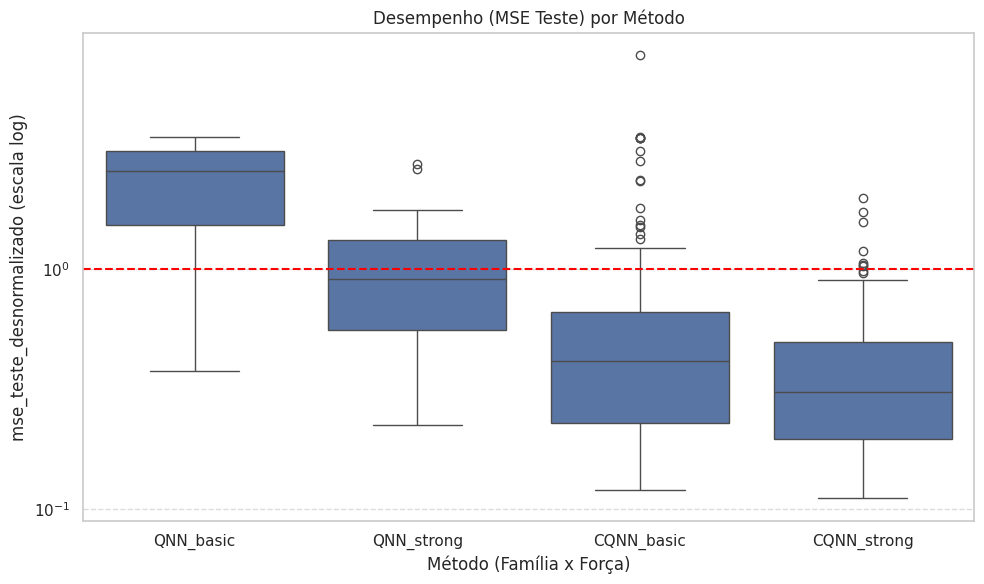

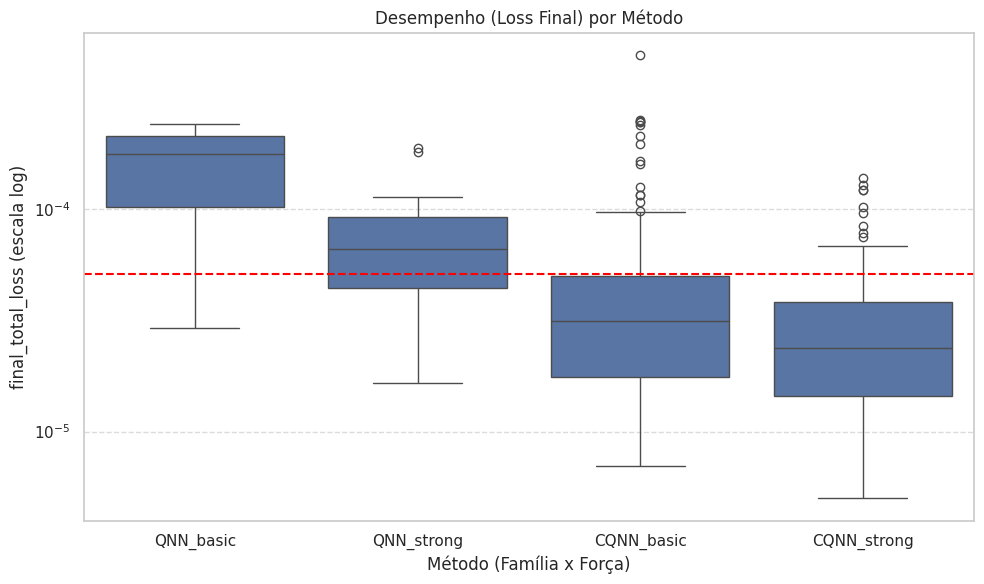

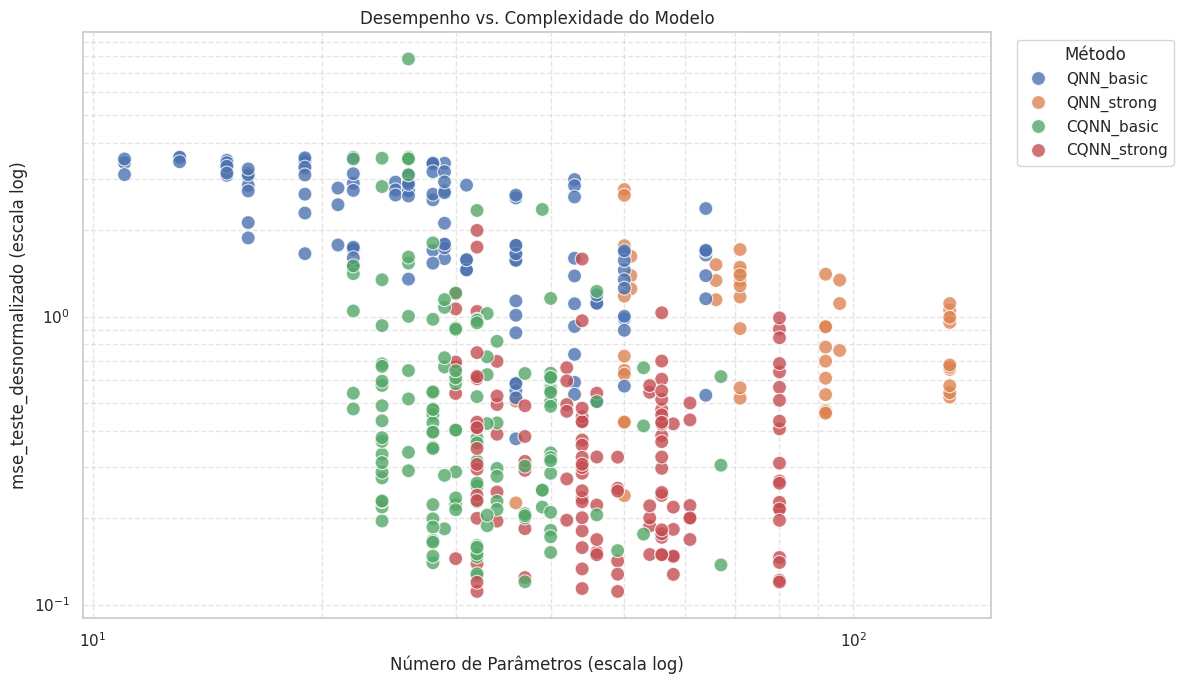

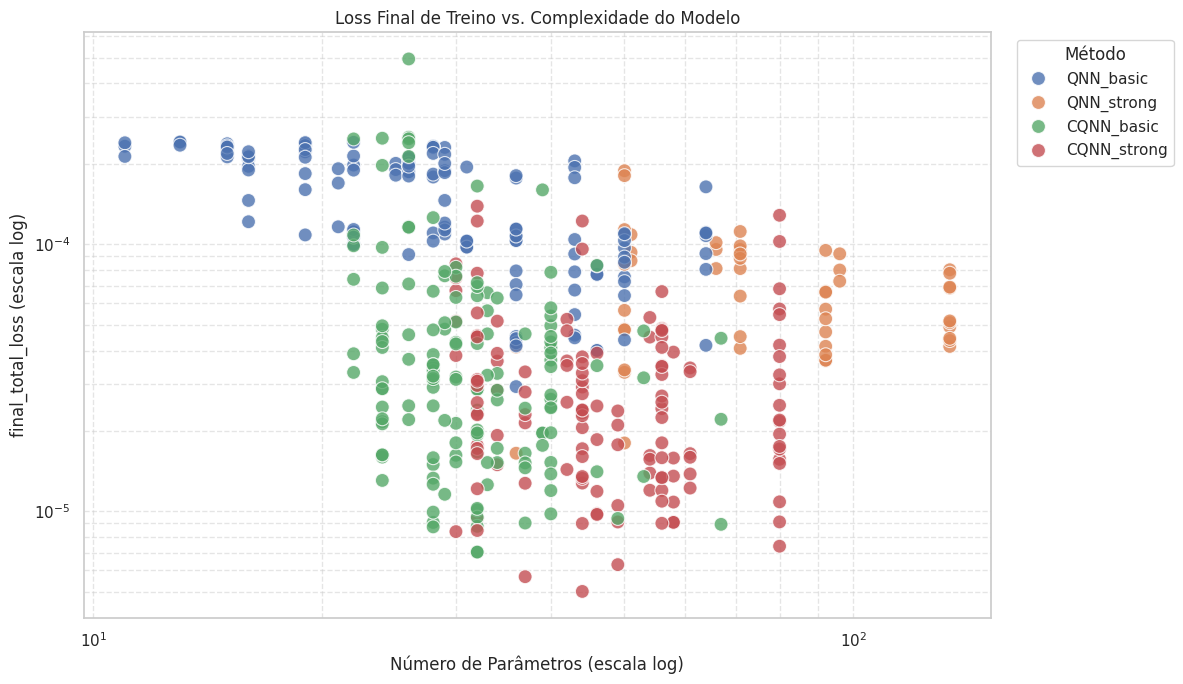

Gerando plots de impacto da arquitetura...


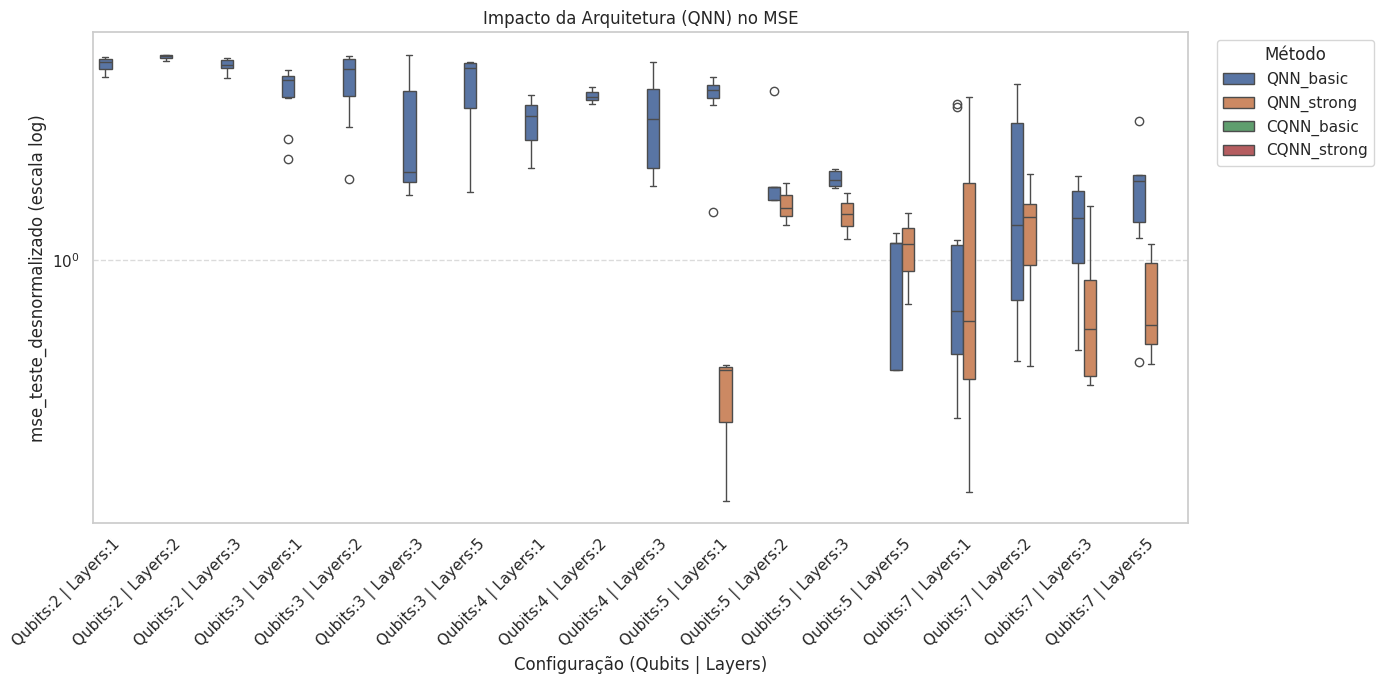

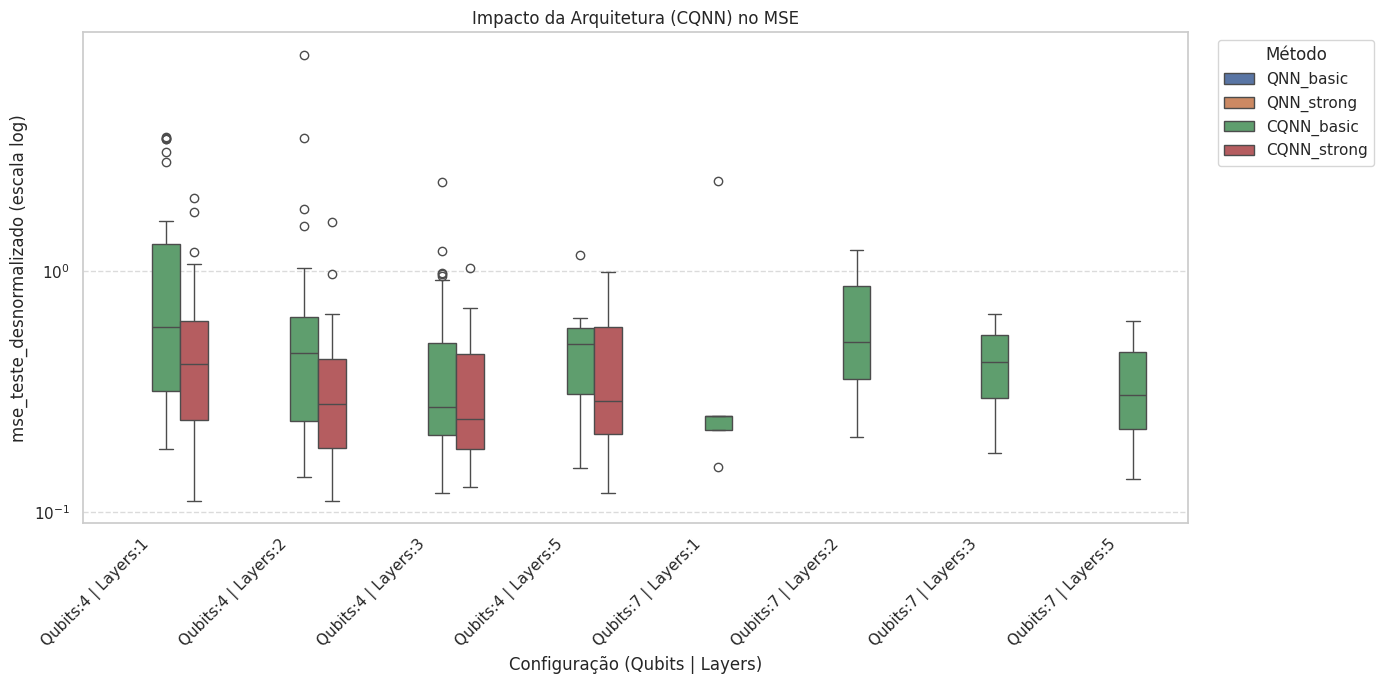

Gerando plot de histórico de loss dos melhores modelos...
AVISO: Não foi possível carregar o histórico de loss: [Errno 2] No such file or directory: 'historicos_loss/loss_qnn_strong_n_qubits_5_n_l_1_seed_1926.json'


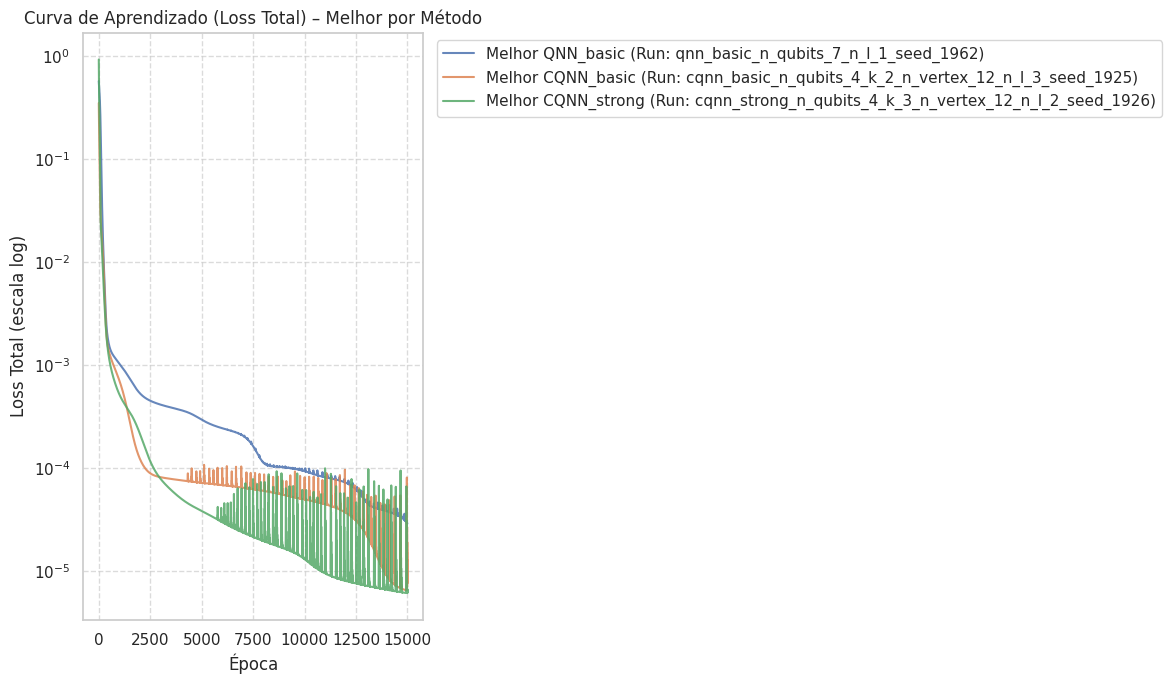

In [43]:
# Diretório onde os resultados foram salvos
RESULTS_DIR = "experimentos_pinn"

SUMMARY_QUANTUM_PATH = os.path.join(RESULTS_DIR, "sumario_quantico.csv")
SUMMARY_CQUANTUM_PATH = os.path.join(RESULTS_DIR, "sumario_cquantico.csv")

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'final_total_loss'  # ou 'mean_last_100_loss'

# Mapeamento de string de ativação para objeto (necessário para recarregar)
activation_map = {
    "Tanh()": nn.Tanh(),
    "ReLU()": nn.ReLU(),
    # Adicione outras ativações se você as usou
}

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0


# =============================================================================
# 0.1 HELPERS PARA NORMALIZAR TIPO E FORÇA (basic/strong) -> CRIAR 'method'
# =============================================================================
def normalize_family(x: str) -> str:
    """Normaliza o nome do tipo de modelo para 'QNN' ou 'CQNN'."""
    if not isinstance(x, str):
        return "QNN"
    x_low = x.lower()
    # variações comuns
    if "cquant" in x_low or "c-qnn" in x_low or "cqnn" in x_low:
        return "CQNN"
    if "qnn" in x_low:
        return "QNN"
    # fallback
    return x.upper()


def infer_strength(row) -> str:
    """
    Tenta inferir 'basic' ou 'strong' a partir de colunas como 'entangler' e 'run_id_prefix'.
    """
    # prioridade 1: entangler
    ent = row.get('entangler', None)
    if isinstance(ent, str):
        el = ent.lower()
        if 'strong' in el:
            return 'strong'
        if 'basic' in el:
            return 'basic'
    # prioridade 2: run_id_prefix
    rip = row.get('run_id_prefix', None)
    if isinstance(rip, str):
        rl = rip.lower()
        if 'strong' in rl:
            return 'strong'
        if 'basic' in rl:
            return 'basic'
    # prioridade 3: run_id
    rid = row.get('run_id', None)
    if isinstance(rid, str):
        rl = rid.lower()
        if 'strong' in rl:
            return 'strong'
        if 'basic' in rl:
            return 'basic'
    # fallback
    return 'basic'


def build_method_col(df: pd.DataFrame) -> pd.DataFrame:
    """Cria coluna 'method' = '{FAMILY}_{STRENGTH}' (e.g., 'QNN_basic', 'CQNN_strong')."""
    df = df.copy()
    # normaliza família
    df['model_family'] = df['model_type'].apply(normalize_family) if 'model_type' in df.columns \
                         else 'QNN'
    # força (basic/strong)
    df['strength'] = df.apply(infer_strength, axis=1)
    # compõe método
    df['method'] = df['model_family'].astype(str) + "_" + df['strength'].astype(str)
    # ordenação preferida
    method_order = ['QNN_basic', 'QNN_strong', 'CQNN_basic', 'CQNN_strong']
    df['method'] = pd.Categorical(df['method'], categories=method_order, ordered=True)
    return df


# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================
print("Carregando sumários de resultados...")
all_dfs = []

try:
    df_q = pd.read_csv(SUMMARY_QUANTUM_PATH)
    all_dfs.append(df_q)
    print(f"Carregado {len(df_q)} runs de '{SUMMARY_QUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_QUANTUM_PATH}' não encontrado. Pulando.")

try:
    df_cq = pd.read_csv(SUMMARY_CQUANTUM_PATH)
    all_dfs.append(df_cq)
    print(f"Carregado {len(df_cq)} runs de '{SUMMARY_CQUANTUM_PATH}'")
except FileNotFoundError:
    print(f"AVISO: '{SUMMARY_CQUANTUM_PATH}' não encontrado. Pulando.")

if not all_dfs:
    print("ERRO: Nenhum arquivo de sumário encontrado. Rode 'run_experiments.py' primeiro.")
    raise SystemExit(1)

# Concatena todos os dataframes para análise comparativa
df_all = pd.concat(all_dfs, ignore_index=True)

# Garantir tipos numéricos
for col in [MSE_COLUMN, LOSS_COLUMN, 'num_params', 'training_time_sec']:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# Construir a coluna 'method'
df_all = build_method_col(df_all)

print("\n--- Sumário dos Experimentos (Amostra) ---")
print(df_all.head())
print("\n")


# =============================================================================
# 2. PLOTS ESTATÍSTICOS (Análise Comparativa)
# =============================================================================
print("Gerando plots estatísticos...")

# --- Plot 2.1: Desempenho (MSE) por Método ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='method', y=MSE_COLUMN)
plt.title('Desempenho (MSE Teste) por Método')
plt.ylabel(f'{MSE_COLUMN} (escala log)')
plt.xlabel('Método (Família x Força)')
plt.yscale('log')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2.2: LOSS por Método ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='method', y=LOSS_COLUMN)
plt.title('Desempenho (Loss Final) por Método')
plt.ylabel(f'{LOSS_COLUMN} (escala log)')
plt.xlabel('Método (Família x Força)')
plt.yscale('log')
# guia opcional (ex.: 1/140**2)
try:
    plt.axhline(y=1/(V_max**2), color='red', linestyle='--', linewidth=1.5)
except Exception:
    pass
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 2.3: Desempenho (MSE) vs. Complexidade (Parâmetros) ---
if {'num_params', MSE_COLUMN}.issubset(df_all.columns):
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_all, x='num_params', y=MSE_COLUMN, hue='method', s=100, alpha=0.8)
    plt.title('Desempenho vs. Complexidade do Modelo')
    plt.ylabel(f'{MSE_COLUMN} (escala log)')
    plt.xlabel('Número de Parâmetros (escala log)')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Plot 2.5: Loss de Treino vs. Número de Parâmetros ---
if {'num_params', LOSS_COLUMN}.issubset(df_all.columns):
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_all, x='num_params', y=LOSS_COLUMN, hue='method', s=100, alpha=0.8)
    plt.title('Loss Final de Treino vs. Complexidade do Modelo')
    plt.ylabel(f'{LOSS_COLUMN} (escala log)')
    plt.xlabel('Número de Parâmetros (escala log)')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- Plot 2.6: Análise de Impacto da Arquitetura por Família (QNN / CQNN) ---
print("Gerando plots de impacto da arquitetura...")

# Tentamos duas famílias; se só houver QNN, apenas QNN será plotado.
for family in ['QNN', 'CQNN']:
    df_subset = df_all[df_all['model_family'] == family].copy()
    if df_subset.empty:
        continue

    # Detecta automaticamente colunas de arquitetura plausíveis
    # (ajuste se você quiser algo fixo)
    candidate_pairs = [
        ('n_qubits', 'n_layers'),
        ('hidden', 'blocks'),
        ('classical_hidden', 'classical_blocks')
    ]
    pair_found = None
    for p1, p2 in candidate_pairs:
        if p1 in df_subset.columns and p2 in df_subset.columns:
            pair_found = (p1, p2)
            break

    if pair_found is None:
        print(f"AVISO: Pulando plot de arquitetura para '{family}' (não encontrei pares de colunas de arquitetura).")
        continue

    p1, p2 = pair_found
    # rótulos bonitos
    label_map = {
        'n_qubits': 'Qubits',
        'n_layers': 'Layers',
        'hidden': 'Hidden',
        'blocks': 'Blocks',
        'classical_hidden': 'Classical Hidden',
        'classical_blocks': 'Classical Blocks'
    }
    l1, l2 = label_map.get(p1, p1), label_map.get(p2, p2)

    # Cria config textual
    df_subset['config'] = f'{l1}:' + df_subset[p1].astype(str) + f' | {l2}:' + df_subset[p2].astype(str)
    df_subset = df_subset.sort_values(by=[p1, p2])

    plt.figure(figsize=(14, 7))
    sns.boxplot(data=df_subset, x='config', y=MSE_COLUMN, hue='method')
    plt.title(f'Impacto da Arquitetura ({family}) no MSE')
    plt.ylabel(f'{MSE_COLUMN} (escala log)')
    plt.xlabel(f'Configuração ({l1} | {l2})')
    plt.yscale('log')
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# =============================================================================
# 3. PLOTS DE HISTÓRICO DE LOSS
# =============================================================================
print("Gerando plot de histórico de loss dos melhores modelos...")
plt.figure(figsize=(12, 7))
plt.title('Curva de Aprendizado (Loss Total) – Melhor por Método')

# Encontra o melhor de cada método
if 'method' in df_all.columns and LOSS_COLUMN in df_all.columns and MSE_COLUMN in df_all.columns:
    methods = [m for m in df_all['method'].cat.categories if m in df_all['method'].unique().tolist()] \
              if hasattr(df_all['method'], 'cat') else df_all['method'].unique()
    for meth in methods:
        df_subset = df_all[df_all['method'] == meth]
        if df_subset.empty:
            continue

        # melhor run por MSE
        try:
            idx_best = df_subset[MSE_COLUMN].idxmin()
        except ValueError:
            continue

        best_run = df_all.loc[idx_best]
        history_path = best_run.get('loss_history_path', None)
        if not isinstance(history_path, str):
            print(f"AVISO: {meth} sem 'loss_history_path'.")
            continue

        history = load_loss_history(history_path)
        if history and 'Total' in history:
            loss_total = history['Total']
            plt.plot(loss_total, label=f"Melhor {meth} (Run: {best_run.get('run_id', 'N/A')})", alpha=0.85)

plt.xlabel('Época')
plt.ylabel('Loss Total (escala log)')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


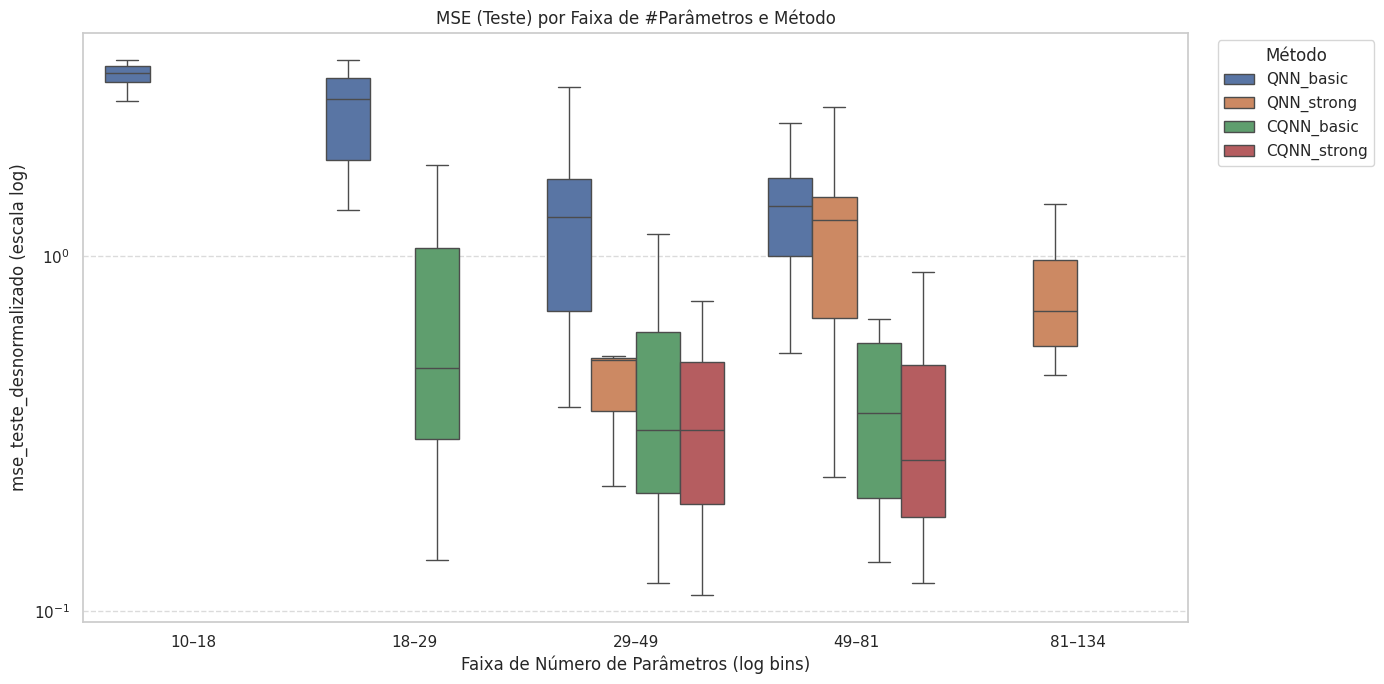

In [44]:
# Cria bins em escala log (ajuste qtd conforme desejar)
bins = np.logspace(np.log10(df_all['num_params'].min()),
                   np.log10(df_all['num_params'].max()),
                   num=6)  # 5 faixas
labels = [f'{int(bins[i])}–{int(bins[i+1])}' for i in range(len(bins)-1)]

df_binned = df_all.copy()
df_binned['params_bin'] = pd.cut(df_binned['num_params'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_binned, x='params_bin', y=MSE_COLUMN, hue='method', showfliers=False)
plt.title('MSE (Teste) por Faixa de #Parâmetros e Método')
plt.ylabel(f'{MSE_COLUMN} (escala log)')
plt.xlabel('Faixa de Número de Parâmetros (log bins)')
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Método', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [45]:
# =============================================================================
# 4. THRESHOLD de convergência
# =============================================================================
# Defina o limiar de loss que caracteriza "convergiu"
THRESH_LOSS = 1/ (V_max**2)   # ex.: mesmo que você já usa nos plots (~1/140^2)
# THRESH_LOSS = 1e-3            # (opção manual)
print("Threshold de loss:", THRESH_LOSS)


Threshold de loss: 5.102040816326531e-05


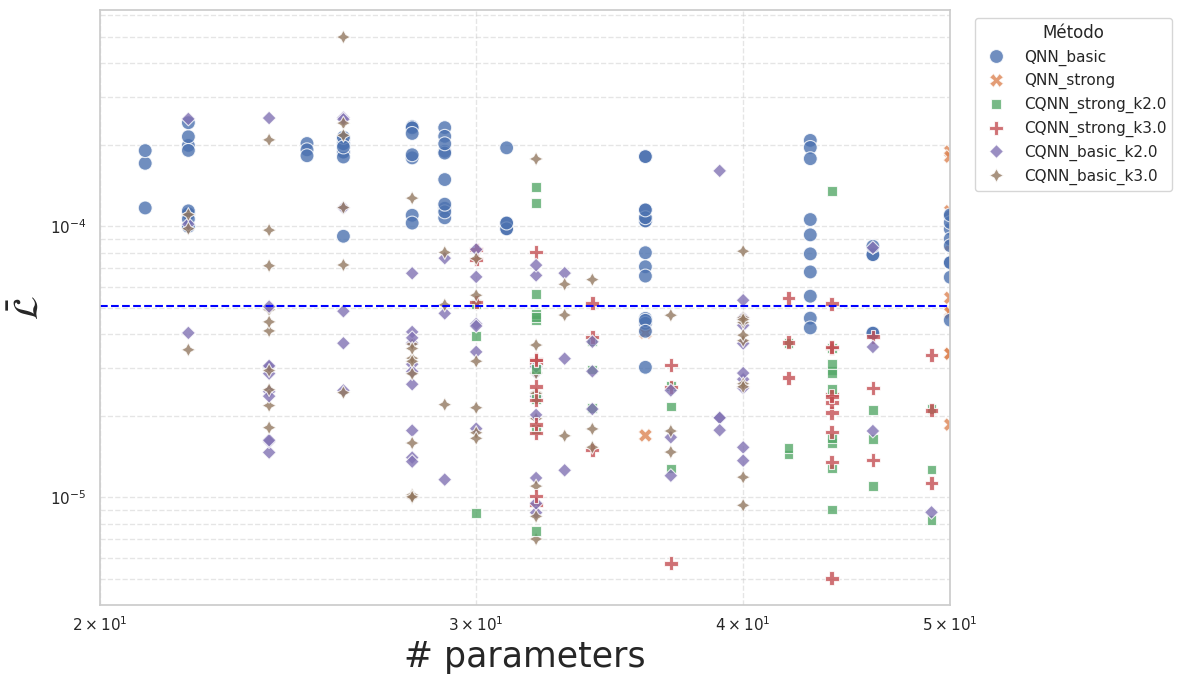

In [46]:
df_plot = df_all.copy()

# Cria uma nova coluna diferenciando CQNN pelo valor de k
df_plot['method_k'] = df_plot.apply(
    lambda r: f"{r['method']}_k{r['k']}" if r['model_family']=='CQNN' else r['method'],
    axis=1
)

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_plot, x='num_params', y='mean_last_100_loss',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(20, 50)
plt.tight_layout()
plt.show()


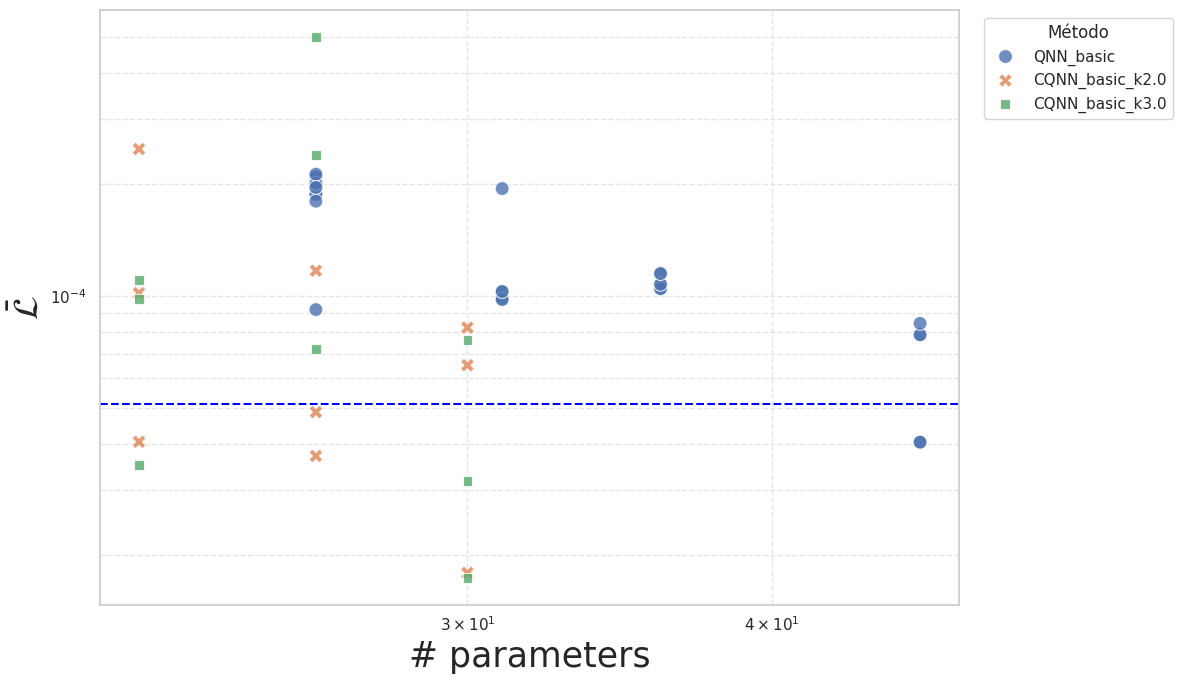

In [47]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    'QNN_basic',
    #'QNN_strong',
    'CQNN_basic_k2.0',
    'CQNN_basic_k3.0'
    #'CQNN_strong_k2.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mean_last_100_loss',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()



Melhores por método (ordenado):
- CQNN_basic_k2.0: run_id=cqnn_basic_n_qubits_4_k_2_n_vertex_5_n_l_3_seed_1926  mean_last_100_loss=1.79434e-05
- CQNN_basic_k3.0: run_id=cqnn_basic_n_qubits_4_k_3_n_vertex_5_n_l_3_seed_1926  mean_last_100_loss=1.73319e-05
- QNN_basic: run_id=qnn_basic_n_qubits_5_n_l_5_seed_1925  mean_last_100_loss=4.03721e-05
AVISO: Não foi possível carregar o histórico de loss: [Errno 2] No such file or directory: 'historicos_loss/loss_qnn_basic_n_qubits_5_n_l_5_seed_1925.json'
AVISO: sem histórico para QNN_basic -> historicos_loss/loss_qnn_basic_n_qubits_5_n_l_5_seed_1925.json


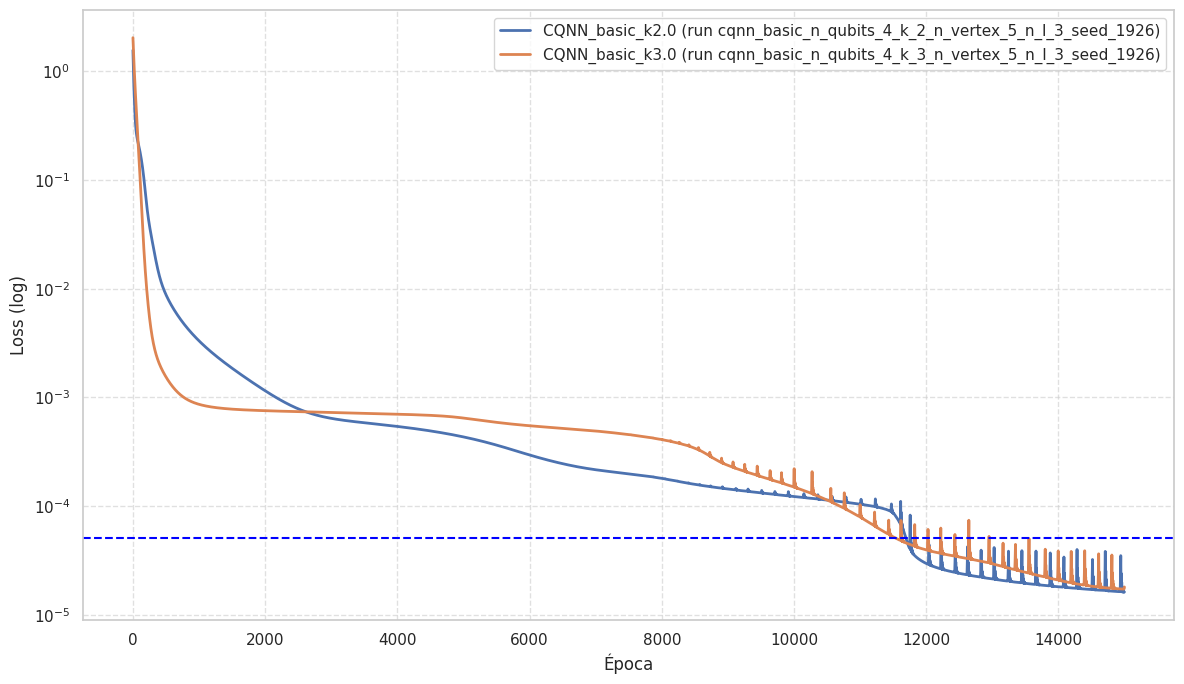

In [48]:
# =========================
# Melhor run por método + plot do histórico
# =========================

METRIC = 'mean_last_100_loss'   # troque para 'mean_last_100_loss' se preferir
HISTORY_KEY = 'Total'                 # ajuste se seu JSON usar outra chave

melhores = []

for metodo in sorted(df_sel['method_k'].unique()):
    df_m = df_sel[df_sel['method_k'] == metodo]
    if df_m.empty or METRIC not in df_m.columns:
        continue
    # escolhe índice do melhor (menor métrica)
    idx_best = df_m[METRIC].idxmin()
    best_row = df_sel.loc[idx_best]
    melhores.append(best_row)

# imprime um resumo rápido
print("Melhores por método (ordenado):")
for r in melhores:
    print(f"- {r['method_k']}: run_id={r['run_id']}  {METRIC}={r[METRIC]:.6g}")

# plota histórico de cada melhor método
plt.figure(figsize=(12, 7))
for r in melhores:
    hist = load_loss_history(r['loss_history_path'])
    if not hist:
        print(f"AVISO: sem histórico para {r['method_k']} -> {r['loss_history_path']}")
        continue
    if HISTORY_KEY not in hist:
        # tenta chaves alternativas comuns
        key_alt = next((k for k in hist.keys() if k.lower() in ['total','loss','train','train_total']), None)
        if key_alt is None:
            print(f"AVISO: chave '{HISTORY_KEY}' não encontrada no histórico de {r['method_k']}.")
            continue
        serie = hist[key_alt]
    else:
        serie = hist[HISTORY_KEY]

    plt.plot(serie, label=f"{r['method_k']} (run {r['run_id']})", linewidth=2),


plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (log)', fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


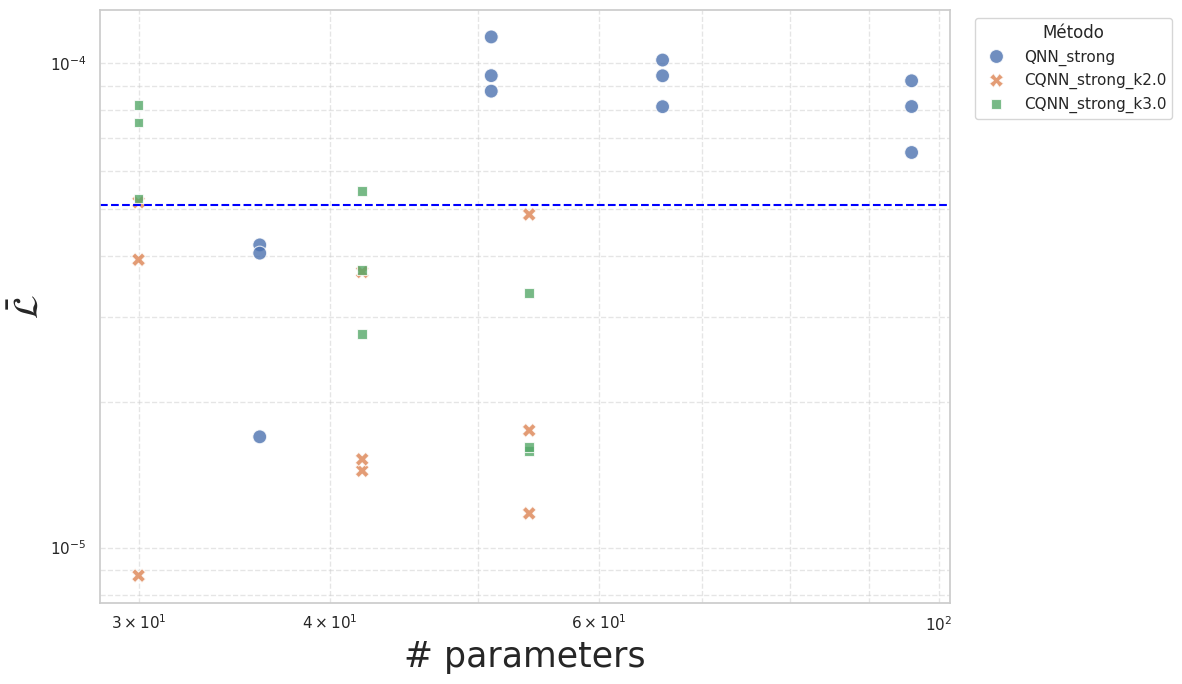

In [49]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    #'QNN_basic',
    'QNN_strong',
    #'CQNN_basic_k2.0',
    #'CQNN_basic_k3.0'
    'CQNN_strong_k2.0',
    'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mean_last_100_loss',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

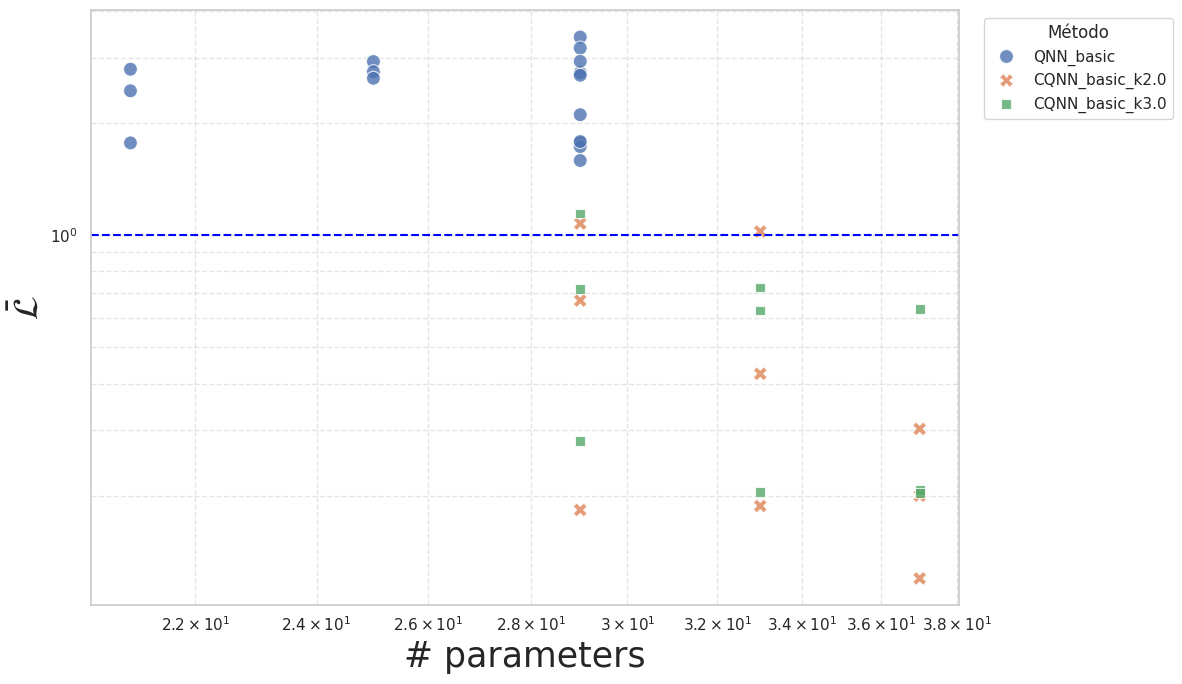

In [50]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    'QNN_basic',
    #'QNN_strong',
    'CQNN_basic_k2.0',
    'CQNN_basic_k3.0'
    #'CQNN_strong_k2.0',
    #'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 4)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 12)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mse_teste_desnormalizado',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

Melhores por método (ordenado):
- CQNN_basic_k2.0: run_id=cqnn_basic_n_qubits_4_k_2_n_vertex_12_n_l_1_seed_1924  mean_last_100_loss=1.16366e-05
- CQNN_basic_k3.0: run_id=cqnn_basic_n_qubits_4_k_3_n_vertex_12_n_l_3_seed_1926  mean_last_100_loss=1.47042e-05
- QNN_basic: run_id=qnn_basic_n_qubits_4_n_l_3_seed_1926  mean_last_100_loss=0.000107546
AVISO: Não foi possível carregar o histórico de loss: [Errno 2] No such file or directory: 'historicos_loss/loss_qnn_basic_n_qubits_4_n_l_3_seed_1926.json'
AVISO: sem histórico para QNN_basic -> historicos_loss/loss_qnn_basic_n_qubits_4_n_l_3_seed_1926.json


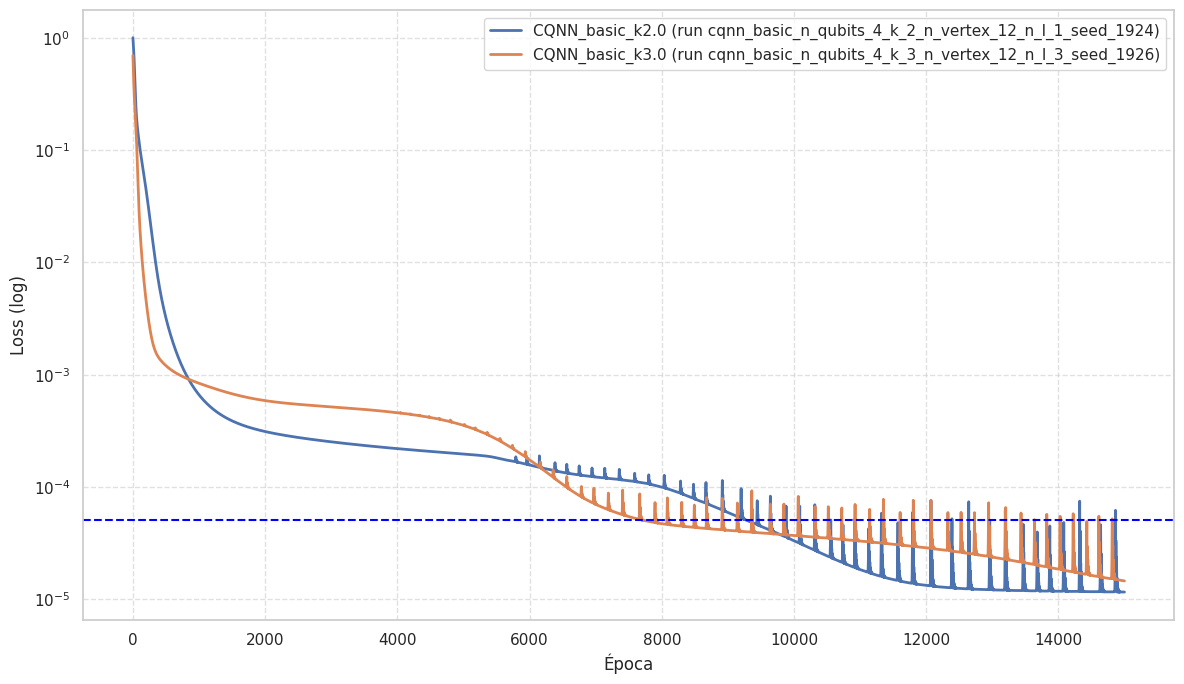

In [51]:
# =========================
# Melhor run por método + plot do histórico
# =========================

METRIC = 'mean_last_100_loss'   # troque para 'mean_last_100_loss' se preferir
HISTORY_KEY = 'Total'                 # ajuste se seu JSON usar outra chave

melhores = []

for metodo in sorted(df_sel['method_k'].unique()):
    df_m = df_sel[df_sel['method_k'] == metodo]
    if df_m.empty or METRIC not in df_m.columns:
        continue
    # escolhe índice do melhor (menor métrica)
    idx_best = df_m[METRIC].idxmin()
    best_row = df_sel.loc[idx_best]
    melhores.append(best_row)

# imprime um resumo rápido
print("Melhores por método (ordenado):")
for r in melhores:
    print(f"- {r['method_k']}: run_id={r['run_id']}  {METRIC}={r[METRIC]:.6g}")

# plota histórico de cada melhor método
plt.figure(figsize=(12, 7))
for r in melhores:
    hist = load_loss_history(r['loss_history_path'])
    if not hist:
        print(f"AVISO: sem histórico para {r['method_k']} -> {r['loss_history_path']}")
        continue
    if HISTORY_KEY not in hist:
        # tenta chaves alternativas comuns
        key_alt = next((k for k in hist.keys() if k.lower() in ['total','loss','train','train_total']), None)
        if key_alt is None:
            print(f"AVISO: chave '{HISTORY_KEY}' não encontrada no histórico de {r['method_k']}.")
            continue
        serie = hist[key_alt]
    else:
        serie = hist[HISTORY_KEY]

    plt.plot(serie, label=f"{r['method_k']} (run {r['run_id']})", linewidth=2),


plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (log)', fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


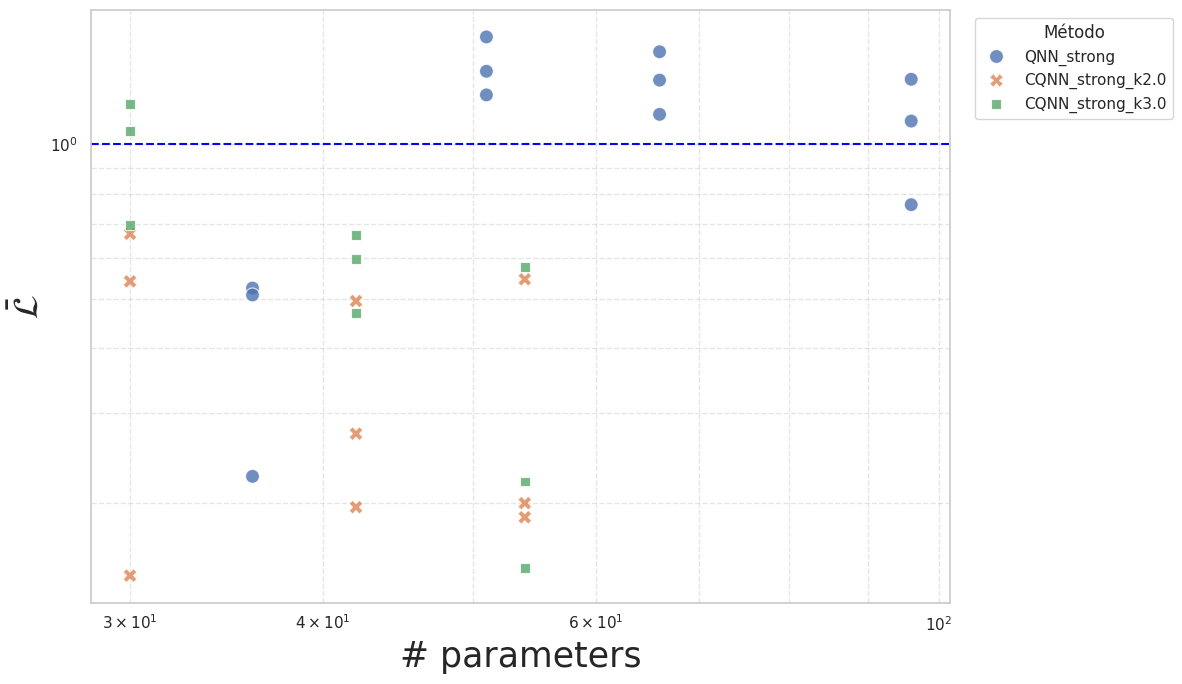

In [52]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    #'QNN_basic',
    'QNN_strong',
    #'CQNN_basic_k2.0',
    #'CQNN_basic_k3.0'
    'CQNN_strong_k2.0',
    'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5 )

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mse_teste_desnormalizado',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

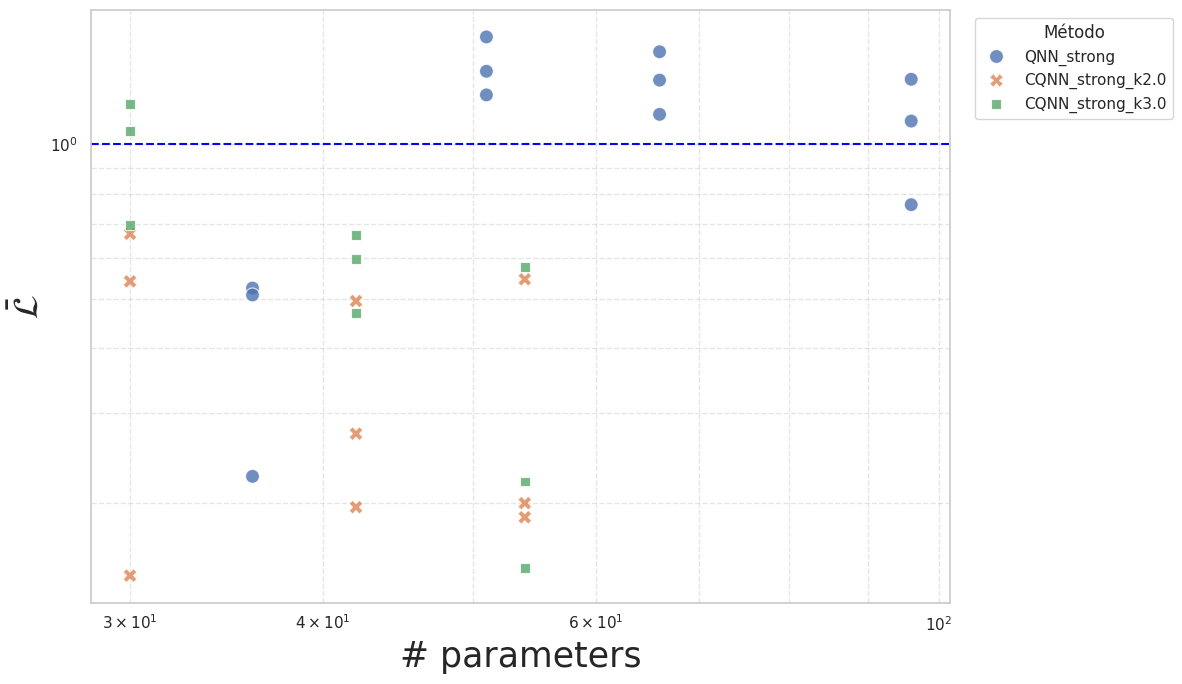

In [53]:
# lista dos métodos que você quer incluir no gráfico
selecionados = [
    #'QNN_basic',
    'QNN_strong',
    #'CQNN_basic_k2.0',
    #'CQNN_basic_k3.0'
    'CQNN_strong_k2.0',
    'CQNN_strong_k3.0'
]

# mantém apenas os métodos escolhidos e com n_qubits = 3
# define o filtro separadamente
filtro_qnn  = (df_plot['model_family'] == 'QNN')  & (df_plot['n_qubits']  == 5)
filtro_cqnn = (df_plot['model_family'] == 'CQNN') & (df_plot['n_vertex'] == 5)

# combina
df_sel = df_plot[(filtro_qnn | filtro_cqnn) & df_plot['method_k'].isin(selecionados)]

# plota
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_sel, x='num_params', y='mse_teste_desnormalizado',
                hue='method_k', style='method_k', s=100, alpha=0.8)

plt.ylabel('$\\bar{\\mathcal{L}}$', fontsize=25)
plt.xlabel('# parameters', fontsize=25)
plt.yscale('log'); plt.xscale('log')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5)
plt.legend(title='Método', bbox_to_anchor=(1.02,1), loc='upper left')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

Melhores por método (ordenado):
- CQNN_strong_k2.0: run_id=cqnn_strong_n_qubits_4_k_2_n_vertex_5_n_l_1_seed_1926  mean_last_100_loss=8.75335e-06
- CQNN_strong_k3.0: run_id=cqnn_strong_n_qubits_4_k_3_n_vertex_5_n_l_3_seed_1924  mean_last_100_loss=1.58056e-05
- QNN_strong: run_id=qnn_strong_n_qubits_5_n_l_1_seed_1926  mean_last_100_loss=1.69362e-05
AVISO: Não foi possível carregar o histórico de loss: [Errno 2] No such file or directory: 'historicos_loss/loss_qnn_strong_n_qubits_5_n_l_1_seed_1926.json'
AVISO: sem histórico para QNN_strong -> historicos_loss/loss_qnn_strong_n_qubits_5_n_l_1_seed_1926.json


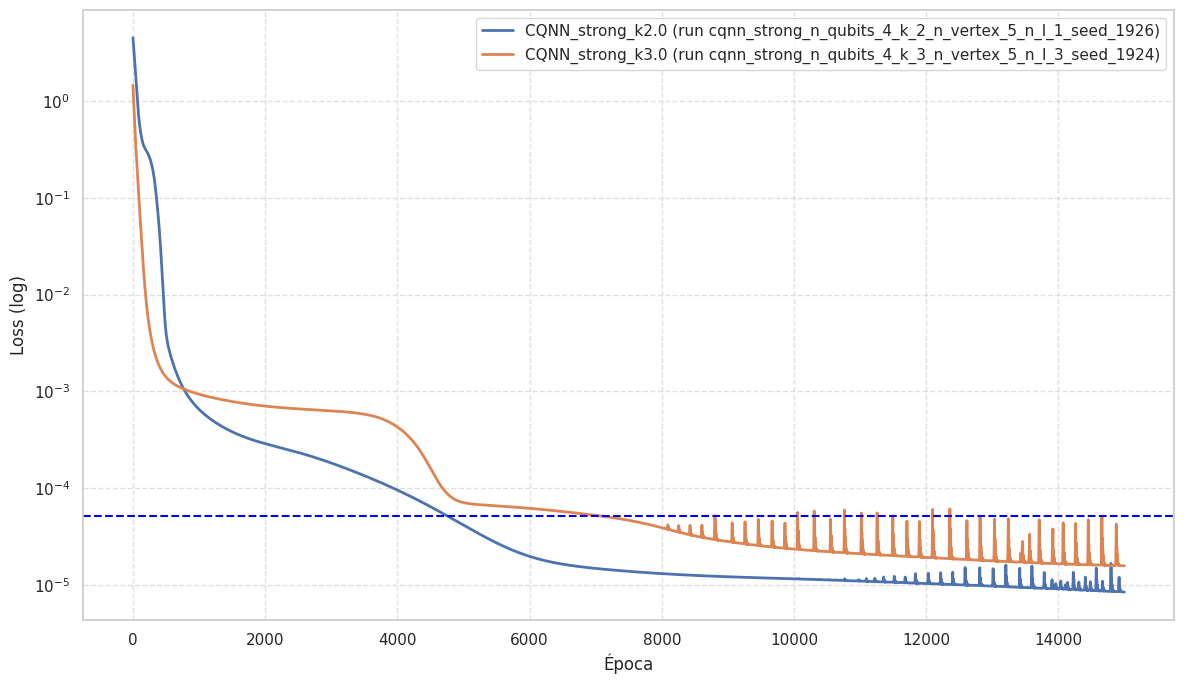

In [54]:
# =========================
# Melhor run por método + plot do histórico
# =========================

METRIC = 'mean_last_100_loss'   # troque para 'mean_last_100_loss' se preferir
HISTORY_KEY = 'Total'                 # ajuste se seu JSON usar outra chave

melhores = []

for metodo in sorted(df_sel['method_k'].unique()):
    df_m = df_sel[df_sel['method_k'] == metodo]
    if df_m.empty or METRIC not in df_m.columns:
        continue
    # escolhe índice do melhor (menor métrica)
    idx_best = df_m[METRIC].idxmin()
    best_row = df_sel.loc[idx_best]
    melhores.append(best_row)

# imprime um resumo rápido
print("Melhores por método (ordenado):")
for r in melhores:
    print(f"- {r['method_k']}: run_id={r['run_id']}  {METRIC}={r[METRIC]:.6g}")

# plota histórico de cada melhor método
plt.figure(figsize=(12, 7))
for r in melhores:
    hist = load_loss_history(r['loss_history_path'])
    if not hist:
        print(f"AVISO: sem histórico para {r['method_k']} -> {r['loss_history_path']}")
        continue
    if HISTORY_KEY not in hist:
        # tenta chaves alternativas comuns
        key_alt = next((k for k in hist.keys() if k.lower() in ['total','loss','train','train_total']), None)
        if key_alt is None:
            print(f"AVISO: chave '{HISTORY_KEY}' não encontrada no histórico de {r['method_k']}.")
            continue
        serie = hist[key_alt]
    else:
        serie = hist[HISTORY_KEY]

    plt.plot(serie, label=f"{r['method_k']} (run {r['run_id']})", linewidth=2),


plt.axhline(y=THRESH_LOSS, color='blue', linestyle='--', linewidth=1.5)
plt.yscale('log')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (log)', fontsize=12)
plt.grid(True, ls='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
